In [1]:
import pypsa
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import numpy_financial as npf
import networkx as nx
from openpyxl import Workbook

In [2]:
# Load the input data
wind_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Generation/Wind_Generation_Data_Input_2022.xlsx', parse_dates=['Timestamp'])
market_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2022.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_high_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCH_Prices.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_low_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCL_Prices.xlsx', parse_dates=['Timestamp'])
dch_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCH_volume_mw.xlsx', parse_dates=['Timestamp'])
dcl_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCL_volume_mw.xlsx', parse_dates=['Timestamp'])

# Set the 'Timestamp' column as the index
wind_data.set_index('Timestamp', inplace=True)
market_prices = market_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_prices = Dynamic_containment_high_prices_data.set_index('Timestamp')['Price (£/MWh)']
dcl_prices = Dynamic_containment_low_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_volume = dch_volume_data.set_index('Timestamp')['Volume (MW)']
dcl_volume = dcl_volume_data.set_index('Timestamp')['Volume (MW)']

# Ensure all data is aligned to the same index
market_prices = market_prices.reindex(wind_data.index, method='nearest')
dch_prices = dch_prices.reindex(wind_data.index, method='nearest')
dcl_prices = dcl_prices.reindex(wind_data.index, method='nearest')
dch_volume = dch_volume.reindex(wind_data.index, method='nearest')
dcl_volume = dcl_volume.reindex(wind_data.index, method='nearest')

# Add a generator for the wind farm
wind_generation_profile = wind_data['Wind Power Output (MW)']

# Add a load for the grid demand
demand_profile = wind_data['Load Demand (MW)']

# Base parameters
base_capex = 626310
base_opex = 28728
base_price_escalation = 0.10
base_discount_rate = 0.07
base_lifetime = 15
base_duration = 2
base_market_prices = market_prices
base_efficiency_store = 0.92
base_efficiency_dispatch = 0.92

# Function to run the optimization and calculate financial metrics
def run_optimization(capex, opex, price_escalation, discount_rate, lifetime, duration, market_prices, efficiency_store, efficiency_dispatch):
    # Initialize the network
    network = pypsa.Network()
    network.set_snapshots(wind_data.index)

    # Add carriers
    network.add("Carrier", "electricity")

    # Add buses
    network.add("Bus", "wind_bus", carrier="electricity")
    network.add("Bus", "grid_bus", carrier="electricity")

    # Add components to the network
    network.add("Generator",
                "wind_turbine",
                bus="wind_bus",
                p_nom=84,
                p_set=wind_generation_profile.values,
                marginal_cost=0,
                capital_cost=0)

    network.add("StorageUnit",
                "battery",
                bus="wind_bus",
                p_nom_extendable=True,
                max_hours=duration,
                marginal_cost=0.01,
                capital_cost=capex,
                cyclic_state_of_charge=True,
                state_of_charge_initial=0,
                efficiency_store=efficiency_store,
                efficiency_dispatch=efficiency_dispatch)

    network.add("Load",
                "grid_demand",
                bus="grid_bus",
                sign=-1,
                p_set=demand_profile.values)

    network.add("Generator",
                "Backup Generator",
                bus="grid_bus",
                p_nom_extendable=True,
                marginal_cost=market_prices.values,
                capital_cost=1500000)

    network.add("Generator",
                "DCH Service",
                bus="grid_bus",
                p_nom_extendable=True,
                marginal_cost=dch_prices.values,
                capital_cost=1700000)

    network.add("Generator",
                "DCL Service",
                bus="grid_bus",
                p_nom_extendable=True,
                marginal_cost=dcl_prices.values,
                capital_cost=1600000)

    network.add("Link",
                "wind_to_grid",
                bus0="wind_bus",
                bus1="grid_bus",
                efficiency=0.95,
                p_nom=82)

    network.add("Link",
                "grid_to_wind",
                bus0="grid_bus",
                bus1="wind_bus",
                efficiency=0.95,
                p_nom=82)

    # Optimize the network
    network.optimize(network.snapshots, solver_name='gurobi', keep_files=True)

    # Extract optimization results
    battery_size_mw = network.storage_units.loc["battery", "p_nom_opt"]
    battery_capacity_mwh = battery_size_mw * network.storage_units.loc["battery", "max_hours"]

    # Extract flows
    battery_dispatch = network.storage_units_t.p_dispatch["battery"]
    battery_store = network.storage_units_t.p_store["battery"]

    # Calculate revenues
    arbitrage_revenue = battery_dispatch * market_prices
    dcl_revenue = battery_dispatch * dcl_prices
    dch_revenue = battery_store * dch_prices
    battery_revenue = arbitrage_revenue.sum() + dcl_revenue.sum() + dch_revenue.sum()

    # Project parameters
    annual_battery_revenue = battery_revenue

    # Total CAPEX
    total_capex = battery_size_mw * capex

    # Calculate annual battery revenues with escalation
    annual_battery_revenues = [(annual_battery_revenue * (1 + price_escalation) ** year) for year in range(int(lifetime))]
    annual_opex = [(opex * battery_size_mw * (1 + price_escalation) ** year) for year in range(int(lifetime))]
    annual_cash_flows = [revenue - opex for revenue, opex in zip(annual_battery_revenues, annual_opex)]
    annual_cash_flows.insert(0, -total_capex)

    # NPV Calculation
    npv = npf.npv(discount_rate, annual_cash_flows)

    # IRR Calculation
    irr = npf.irr(annual_cash_flows) * 100

    # Total discounted OPEX
    total_opex = sum([opex / ((1 + discount_rate) ** year) for year, opex in enumerate(annual_opex, start=1)])

    # Total discounted costs
    total_discounted_costs = total_capex + total_opex

    # Total energy dispatched over the lifetime (MWh)
    total_energy_dispatched = battery_dispatch.sum() * lifetime

    # LCOS Calculation
    lcos = total_discounted_costs / total_energy_dispatched

    return npv, irr, lcos

# Parameters for sensitivity analysis
parameters = {
    "capex_per_mw": base_capex,
    "opex_per_mw_per_year": base_opex,
    "price_escalation_rate": base_price_escalation,
    "discount_rate": base_discount_rate,
    "battery_lifetime": base_lifetime,
    "battery_duration": base_duration,
    "market_price": base_market_prices,
    "round_trip_efficiency": base_efficiency_store * base_efficiency_dispatch
}

# Results storage
results = []

# Run sensitivity analysis
for param in parameters.keys():
    for change in [1.1, 0.90]:
        modified_parameters = parameters.copy()
        modified_value = parameters[param] * change
        
        # Ensure battery_lifetime remains an integer
        if param == "battery_lifetime":
            modified_value = int(modified_value)
        
        modified_parameters[param] = modified_value
        
        # Adjust efficiency parameters if round_trip_efficiency is changed
        if param == "round_trip_efficiency":
            modified_parameters["efficiency_store"] = np.sqrt(modified_value)
            modified_parameters["efficiency_dispatch"] = np.sqrt(modified_value)
        else:
            modified_parameters["efficiency_store"] = base_efficiency_store
            modified_parameters["efficiency_dispatch"] = base_efficiency_dispatch

        npv, irr, lcos = run_optimization(
            modified_parameters["capex_per_mw"],
            modified_parameters["opex_per_mw_per_year"],
            modified_parameters["price_escalation_rate"],
            modified_parameters["discount_rate"],
            modified_parameters["battery_lifetime"],
            modified_parameters["battery_duration"],
            modified_parameters["market_price"],
            modified_parameters["efficiency_store"],
            modified_parameters["efficiency_dispatch"]
        )
        
        results.append({
            'parameter': param,
            'change': change,
            'NPV': npv,
            'IRR': irr,
            'LCOS': lcos
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel sheet
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Sensitivity/Sensitivity_Analysis_Parameter_Impact.xlsx'
results_df.to_excel(output_path, index=False)

print("Sensitivity analysis results saved to", output_path)


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 106.15it/s]
INFO:linopy.io: Writing time: 0.5s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-28iddv0t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-28iddv0t.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x691eba98


INFO:gurobipy:Model fingerprint: 0x691eba98


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.31020123e+11 -2.63543102e+10  8.46e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.31020123e+11 -2.63543102e+10  8.46e+04 3.22e+01  4.24e+08     0s


   1   4.36008345e+11 -1.37432135e+12  1.94e+04 1.79e+03  8.91e+07     0s


INFO:gurobipy:   1   4.36008345e+11 -1.37432135e+12  1.94e+04 1.79e+03  8.91e+07     0s


   2   4.03699304e+11 -3.75317389e+11  3.89e+03 1.31e+02  1.39e+07     0s


INFO:gurobipy:   2   4.03699304e+11 -3.75317389e+11  3.89e+03 1.31e+02  1.39e+07     0s


   3   2.39894829e+11  5.17193102e+10  8.96e+02 2.39e+00  2.37e+06     0s


INFO:gurobipy:   3   2.39894829e+11  5.17193102e+10  8.96e+02 2.39e+00  2.37e+06     0s


   4   1.98989000e+11  8.32464040e+10  5.83e+02 5.82e-09  1.27e+06     0s


INFO:gurobipy:   4   1.98989000e+11  8.32464040e+10  5.83e+02 5.82e-09  1.27e+06     0s


   5   1.91879359e+11  9.57224773e+10  4.84e+02 5.82e-09  1.00e+06     0s


INFO:gurobipy:   5   1.91879359e+11  9.57224773e+10  4.84e+02 5.82e-09  1.00e+06     0s


   6   1.85828951e+11  1.11589158e+11  4.11e+02 8.46e-11  7.48e+05     0s


INFO:gurobipy:   6   1.85828951e+11  1.11589158e+11  4.11e+02 8.46e-11  7.48e+05     0s


   7   1.66916201e+11  1.32943083e+11  1.66e+02 9.43e-09  2.94e+05     0s


INFO:gurobipy:   7   1.66916201e+11  1.32943083e+11  1.66e+02 9.43e-09  2.94e+05     0s


   8   1.60368327e+11  1.44091949e+11  7.85e+01 2.08e-08  1.21e+05     0s


INFO:gurobipy:   8   1.60368327e+11  1.44091949e+11  7.85e+01 2.08e-08  1.21e+05     0s


   9   1.56547695e+11  1.48723739e+11  3.10e+01 1.04e-08  5.25e+04     0s


INFO:gurobipy:   9   1.56547695e+11  1.48723739e+11  3.10e+01 1.04e-08  5.25e+04     0s


  10   1.54937473e+11  1.51619238e+11  1.47e+01 2.77e-08  2.11e+04     0s


INFO:gurobipy:  10   1.54937473e+11  1.51619238e+11  1.47e+01 2.77e-08  2.11e+04     0s


  11   1.54046785e+11  1.52672632e+11  6.04e+00 2.40e-08  8.49e+03     1s


INFO:gurobipy:  11   1.54046785e+11  1.52672632e+11  6.04e+00 2.40e-08  8.49e+03     1s


  12   1.53547066e+11  1.53038296e+11  2.00e+00 4.47e-08  3.11e+03     1s


INFO:gurobipy:  12   1.53547066e+11  1.53038296e+11  2.00e+00 4.47e-08  3.11e+03     1s


  13   1.53426010e+11  1.53104000e+11  1.28e+00 2.37e-07  1.97e+03     1s


INFO:gurobipy:  13   1.53426010e+11  1.53104000e+11  1.28e+00 2.37e-07  1.97e+03     1s


  14   1.53346297e+11  1.53132842e+11  8.13e-01 2.70e-07  1.30e+03     1s


INFO:gurobipy:  14   1.53346297e+11  1.53132842e+11  8.13e-01 2.70e-07  1.30e+03     1s


  15   1.53301793e+11  1.53172358e+11  5.53e-01 3.11e-07  7.89e+02     1s


INFO:gurobipy:  15   1.53301793e+11  1.53172358e+11  5.53e-01 3.11e-07  7.89e+02     1s


  16   1.53281208e+11  1.53181249e+11  4.37e-01 2.44e-07  6.10e+02     1s


INFO:gurobipy:  16   1.53281208e+11  1.53181249e+11  4.37e-01 2.44e-07  6.10e+02     1s


  17   1.53279349e+11  1.53183988e+11  4.26e-01 2.30e-07  5.82e+02     1s


INFO:gurobipy:  17   1.53279349e+11  1.53183988e+11  4.26e-01 2.30e-07  5.82e+02     1s


  18   1.53277302e+11  1.53206271e+11  4.08e-01 2.17e-07  4.34e+02     1s


INFO:gurobipy:  18   1.53277302e+11  1.53206271e+11  4.08e-01 2.17e-07  4.34e+02     1s


  19   1.53267264e+11  1.53246696e+11  2.18e-01 6.36e-08  1.27e+02     1s


INFO:gurobipy:  19   1.53267264e+11  1.53246696e+11  2.18e-01 6.36e-08  1.27e+02     1s


  20   1.53256070e+11  1.53252061e+11  3.26e-02 1.23e-07  2.46e+01     1s


INFO:gurobipy:  20   1.53256070e+11  1.53252061e+11  3.26e-02 1.23e-07  2.46e+01     1s


  21   1.53254551e+11  1.53252787e+11  1.29e-02 5.65e-08  1.08e+01     1s


INFO:gurobipy:  21   1.53254551e+11  1.53252787e+11  1.29e-02 5.65e-08  1.08e+01     1s


  22   1.53254037e+11  1.53253194e+11  6.47e-03 2.17e-08  5.17e+00     1s


INFO:gurobipy:  22   1.53254037e+11  1.53253194e+11  6.47e-03 2.17e-08  5.17e+00     1s


  23   1.53253750e+11  1.53253369e+11  3.04e-03 8.09e-09  2.34e+00     1s


INFO:gurobipy:  23   1.53253750e+11  1.53253369e+11  3.04e-03 8.09e-09  2.34e+00     1s


  24   1.53253611e+11  1.53253432e+11  1.42e-03 3.84e-09  1.10e+00     1s


INFO:gurobipy:  24   1.53253611e+11  1.53253432e+11  1.42e-03 3.84e-09  1.10e+00     1s


  25   1.53253546e+11  1.53253462e+11  7.03e-04 6.05e-09  5.14e-01     1s


INFO:gurobipy:  25   1.53253546e+11  1.53253462e+11  7.03e-04 6.05e-09  5.14e-01     1s


  26   1.53253512e+11  1.53253473e+11  3.47e-04 3.61e-09  2.37e-01     1s


INFO:gurobipy:  26   1.53253512e+11  1.53253473e+11  3.47e-04 3.61e-09  2.37e-01     1s


  27   1.53253495e+11  1.53253484e+11  1.52e-04 9.31e-10  6.80e-02     1s


INFO:gurobipy:  27   1.53253495e+11  1.53253484e+11  1.52e-04 9.31e-10  6.80e-02     1s


  28   1.53253487e+11  1.53253485e+11  3.01e-05 1.63e-09  1.08e-02     1s


INFO:gurobipy:  28   1.53253487e+11  1.53253485e+11  3.01e-05 1.63e-09  1.08e-02     1s


  29   1.53253486e+11  1.53253486e+11  1.08e-05 2.79e-09  2.57e-03     1s


INFO:gurobipy:  29   1.53253486e+11  1.53253486e+11  1.08e-05 2.79e-09  2.57e-03     1s


  30   1.53253486e+11  1.53253486e+11  4.59e-06 3.25e-08  9.93e-04     1s


INFO:gurobipy:  30   1.53253486e+11  1.53253486e+11  4.59e-06 3.25e-08  9.93e-04     1s


  31   1.53253486e+11  1.53253486e+11  2.01e-06 6.60e-08  4.02e-04     1s


INFO:gurobipy:  31   1.53253486e+11  1.53253486e+11  2.01e-06 6.60e-08  4.02e-04     1s


  32   1.53253486e+11  1.53253486e+11  2.29e-07 9.92e-08  4.73e-05     1s


INFO:gurobipy:  32   1.53253486e+11  1.53253486e+11  2.29e-07 9.92e-08  4.73e-05     1s


  33   1.53253486e+11  1.53253486e+11  2.65e-08 1.21e-07  1.56e-06     1s


INFO:gurobipy:  33   1.53253486e+11  1.53253486e+11  2.65e-08 1.21e-07  1.56e-06     1s


INFO:gurobipy:


Barrier performed 33 iterations in 1.20 seconds (1.34 work units)


INFO:gurobipy:Barrier performed 33 iterations in 1.20 seconds (1.34 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5325349e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48692    1.5325349e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48692 iterations and 1.25 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.25 seconds (1.82 work units)


Optimal objective  1.532534860e+11


INFO:gurobipy:Optimal objective  1.532534860e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 68.73it/s]
INFO:linopy.io: Writing time: 0.72s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-xj85bcb3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-xj85bcb3.lp


Reading time = 0.21 seconds


INFO:gurobipy:Reading time = 0.21 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x39c355ed


INFO:gurobipy:Model fingerprint: 0x39c355ed


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.27698471e+11 -2.63345116e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.27698471e+11 -2.63345116e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.26641742e+11 -1.37499511e+12  1.94e+04 1.78e+03  8.89e+07     0s


INFO:gurobipy:   1   4.26641742e+11 -1.37499511e+12  1.94e+04 1.78e+03  8.89e+07     0s


   2   3.94837764e+11 -3.76891745e+11  3.90e+03 1.33e+02  1.39e+07     0s


INFO:gurobipy:   2   3.94837764e+11 -3.76891745e+11  3.90e+03 1.33e+02  1.39e+07     0s


   3   2.34868681e+11  5.16868818e+10  8.89e+02 2.46e+00  2.33e+06     0s


INFO:gurobipy:   3   2.34868681e+11  5.16868818e+10  8.89e+02 2.46e+00  2.33e+06     0s


   4   1.94657028e+11  8.33067609e+10  5.71e+02 4.54e-09  1.23e+06     0s


INFO:gurobipy:   4   1.94657028e+11  8.33067609e+10  5.71e+02 4.54e-09  1.23e+06     0s


   5   1.89187988e+11  9.48175779e+10  4.84e+02 9.31e-10  9.97e+05     0s


INFO:gurobipy:   5   1.89187988e+11  9.48175779e+10  4.84e+02 9.31e-10  9.97e+05     0s


   6   1.83778636e+11  1.11461660e+11  4.14e+02 5.70e-09  7.39e+05     0s


INFO:gurobipy:   6   1.83778636e+11  1.11461660e+11  4.14e+02 5.70e-09  7.39e+05     0s


   7   1.66776331e+11  1.34286249e+11  1.56e+02 5.82e-10  2.77e+05     0s


INFO:gurobipy:   7   1.66776331e+11  1.34286249e+11  1.56e+02 5.82e-10  2.77e+05     0s


   8   1.59760217e+11  1.45243810e+11  6.71e+01 1.98e-08  1.06e+05     0s


INFO:gurobipy:   8   1.59760217e+11  1.45243810e+11  6.71e+01 1.98e-08  1.06e+05     0s


   9   1.56287416e+11  1.50197144e+11  2.60e+01 8.96e-09  4.01e+04     1s


INFO:gurobipy:   9   1.56287416e+11  1.50197144e+11  2.60e+01 8.96e-09  4.01e+04     1s


  10   1.54862911e+11  1.51871000e+11  1.21e+01 6.05e-09  1.89e+04     1s


INFO:gurobipy:  10   1.54862911e+11  1.51871000e+11  1.21e+01 6.05e-09  1.89e+04     1s


  11   1.54069618e+11  1.52744598e+11  5.67e+00 1.35e-08  8.19e+03     1s


INFO:gurobipy:  11   1.54069618e+11  1.52744598e+11  5.67e+00 1.35e-08  8.19e+03     1s


  12   1.53610700e+11  1.53049801e+11  2.36e+00 1.43e-08  3.44e+03     1s


INFO:gurobipy:  12   1.53610700e+11  1.53049801e+11  2.36e+00 1.43e-08  3.44e+03     1s


  13   1.53422925e+11  1.53125447e+11  1.28e+00 1.44e-07  1.82e+03     1s


INFO:gurobipy:  13   1.53422925e+11  1.53125447e+11  1.28e+00 1.44e-07  1.82e+03     1s


  14   1.53354243e+11  1.53144629e+11  8.72e-01 1.54e-07  1.28e+03     1s


INFO:gurobipy:  14   1.53354243e+11  1.53144629e+11  8.72e-01 1.54e-07  1.28e+03     1s


  15   1.53300585e+11  1.53178059e+11  5.58e-01 1.37e-07  7.49e+02     1s


INFO:gurobipy:  15   1.53300585e+11  1.53178059e+11  5.58e-01 1.37e-07  7.49e+02     1s


  16   1.53275986e+11  1.53183239e+11  4.14e-01 1.05e-07  5.66e+02     1s


INFO:gurobipy:  16   1.53275986e+11  1.53183239e+11  4.14e-01 1.05e-07  5.66e+02     1s


  17   1.53270818e+11  1.53187184e+11  3.86e-01 9.09e-08  5.11e+02     1s


INFO:gurobipy:  17   1.53270818e+11  1.53187184e+11  3.86e-01 9.09e-08  5.11e+02     1s


  18   1.53267211e+11  1.53222609e+11  2.90e-01 6.12e-08  2.73e+02     1s


INFO:gurobipy:  18   1.53267211e+11  1.53222609e+11  2.90e-01 6.12e-08  2.73e+02     1s


  19   1.53250601e+11  1.53239575e+11  7.65e-02 1.28e-09  6.76e+01     1s


INFO:gurobipy:  19   1.53250601e+11  1.53239575e+11  7.65e-02 1.28e-09  6.76e+01     1s


  20   1.53246845e+11  1.53242514e+11  3.51e-02 1.05e-09  2.66e+01     1s


INFO:gurobipy:  20   1.53246845e+11  1.53242514e+11  3.51e-02 1.05e-09  2.66e+01     1s


  21   1.53244697e+11  1.53243069e+11  1.24e-02 2.21e-08  1.00e+01     1s


INFO:gurobipy:  21   1.53244697e+11  1.53243069e+11  1.24e-02 2.21e-08  1.00e+01     1s


  22   1.53244137e+11  1.53243255e+11  6.67e-03 4.07e-09  5.42e+00     1s


INFO:gurobipy:  22   1.53244137e+11  1.53243255e+11  6.67e-03 4.07e-09  5.42e+00     1s


  23   1.53243671e+11  1.53243382e+11  1.98e-03 7.57e-10  1.77e+00     1s


INFO:gurobipy:  23   1.53243671e+11  1.53243382e+11  1.98e-03 7.57e-10  1.77e+00     1s


  24   1.53243532e+11  1.53243443e+11  6.13e-04 6.87e-09  5.42e-01     1s


INFO:gurobipy:  24   1.53243532e+11  1.53243443e+11  6.13e-04 6.87e-09  5.42e-01     1s


  25   1.53243494e+11  1.53243460e+11  2.53e-04 1.56e-08  2.08e-01     1s


INFO:gurobipy:  25   1.53243494e+11  1.53243460e+11  2.53e-04 1.56e-08  2.08e-01     1s


  26   1.53243476e+11  1.53243463e+11  9.59e-05 2.91e-09  8.18e-02     1s


INFO:gurobipy:  26   1.53243476e+11  1.53243463e+11  9.59e-05 2.91e-09  8.18e-02     1s


  27   1.53243467e+11  1.53243465e+11  2.24e-05 4.77e-09  1.79e-02     1s


INFO:gurobipy:  27   1.53243467e+11  1.53243465e+11  2.24e-05 4.77e-09  1.79e-02     1s


  28   1.53243466e+11  1.53243465e+11  9.72e-06 2.33e-09  7.28e-03     1s


INFO:gurobipy:  28   1.53243466e+11  1.53243465e+11  9.72e-06 2.33e-09  7.28e-03     1s


  29   1.53243466e+11  1.53243465e+11  5.40e-06 1.02e-08  1.88e-03     1s


INFO:gurobipy:  29   1.53243466e+11  1.53243465e+11  5.40e-06 1.02e-08  1.88e-03     1s


  30   1.53243465e+11  1.53243465e+11  4.63e-07 2.34e-08  2.46e-04     1s


INFO:gurobipy:  30   1.53243465e+11  1.53243465e+11  4.63e-07 2.34e-08  2.46e-04     1s


  31   1.53243465e+11  1.53243465e+11  5.78e-08 1.95e-07  2.58e-05     2s


INFO:gurobipy:  31   1.53243465e+11  1.53243465e+11  5.78e-08 1.95e-07  2.58e-05     2s


  32   1.53243465e+11  1.53243465e+11  3.48e-08 3.00e-07  3.78e-06     2s


INFO:gurobipy:  32   1.53243465e+11  1.53243465e+11  3.48e-08 3.00e-07  3.78e-06     2s


  33   1.53243465e+11  1.53243465e+11  8.29e-09 1.68e-07  6.61e-09     2s


INFO:gurobipy:  33   1.53243465e+11  1.53243465e+11  8.29e-09 1.68e-07  6.61e-09     2s


INFO:gurobipy:


Barrier solved model in 33 iterations and 1.60 seconds (1.33 work units)


INFO:gurobipy:Barrier solved model in 33 iterations and 1.60 seconds (1.33 work units)


Optimal objective 1.53243465e+11


INFO:gurobipy:Optimal objective 1.53243465e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2817 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:    2817 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


    4341 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    4341 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.1169285e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.1169285e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324347e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   48692    1.5324347e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 48692 iterations and 1.89 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.89 seconds (1.82 work units)


Optimal objective  1.532434653e+11


INFO:gurobipy:Optimal objective  1.532434653e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 67.20it/s]
INFO:linopy.io: Writing time: 0.58s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-b0f6dcjh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-b0f6dcjh.lp


Reading time = 0.27 seconds


INFO:gurobipy:Reading time = 0.27 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x6d21dd03


INFO:gurobipy:Model fingerprint: 0x6d21dd03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


INFO:gurobipy:   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


INFO:gurobipy:   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


INFO:gurobipy:   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


INFO:gurobipy:   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


INFO:gurobipy:   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


INFO:gurobipy:   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


INFO:gurobipy:   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


INFO:gurobipy:   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     1s


INFO:gurobipy:   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     1s


  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     1s


INFO:gurobipy:  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     1s


  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


INFO:gurobipy:  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


INFO:gurobipy:  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


INFO:gurobipy:  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


INFO:gurobipy:  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


INFO:gurobipy:  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


INFO:gurobipy:  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


INFO:gurobipy:  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


INFO:gurobipy:  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


INFO:gurobipy:  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


INFO:gurobipy:  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


INFO:gurobipy:  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


INFO:gurobipy:  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


INFO:gurobipy:  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


INFO:gurobipy:  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


INFO:gurobipy:  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


INFO:gurobipy:  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


INFO:gurobipy:  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


INFO:gurobipy:  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


INFO:gurobipy:  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


INFO:gurobipy:  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


INFO:gurobipy:  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


INFO:gurobipy:  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


INFO:gurobipy:  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


INFO:gurobipy:


Barrier performed 33 iterations in 1.39 seconds (1.34 work units)


INFO:gurobipy:Barrier performed 33 iterations in 1.39 seconds (1.34 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48692 iterations and 1.44 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.44 seconds (1.82 work units)


Optimal objective  1.532484756e+11


INFO:gurobipy:Optimal objective  1.532484756e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 68.96it/s]
INFO:linopy.io: Writing time: 0.76s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-8k2sbrrb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-8k2sbrrb.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x6d21dd03


INFO:gurobipy:Model fingerprint: 0x6d21dd03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


INFO:gurobipy:   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


INFO:gurobipy:   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


INFO:gurobipy:   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


INFO:gurobipy:   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


INFO:gurobipy:   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


INFO:gurobipy:   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


INFO:gurobipy:   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


INFO:gurobipy:   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


INFO:gurobipy:   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


INFO:gurobipy:  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


INFO:gurobipy:  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


INFO:gurobipy:  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


INFO:gurobipy:  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


INFO:gurobipy:  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


INFO:gurobipy:  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


INFO:gurobipy:  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


INFO:gurobipy:  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


INFO:gurobipy:  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


INFO:gurobipy:  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


INFO:gurobipy:  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


INFO:gurobipy:  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


INFO:gurobipy:  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


INFO:gurobipy:  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


INFO:gurobipy:  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


INFO:gurobipy:  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


INFO:gurobipy:  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


INFO:gurobipy:  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


INFO:gurobipy:  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


INFO:gurobipy:  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


INFO:gurobipy:  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


INFO:gurobipy:  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


INFO:gurobipy:  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


INFO:gurobipy:


Barrier performed 32 iterations in 1.15 seconds (1.30 work units)


INFO:gurobipy:Barrier performed 32 iterations in 1.15 seconds (1.30 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48692 iterations and 1.20 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.20 seconds (1.82 work units)


Optimal objective  1.532484756e+11


INFO:gurobipy:Optimal objective  1.532484756e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 102.31it/s]
INFO:linopy.io: Writing time: 0.62s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-cqrcbztx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-cqrcbztx.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x6d21dd03


INFO:gurobipy:Model fingerprint: 0x6d21dd03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


INFO:gurobipy:   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


INFO:gurobipy:   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


INFO:gurobipy:   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


INFO:gurobipy:   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


INFO:gurobipy:   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


INFO:gurobipy:   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


INFO:gurobipy:   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     1s


INFO:gurobipy:   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     1s


   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     1s


INFO:gurobipy:   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     1s


  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     1s


INFO:gurobipy:  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     1s


  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


INFO:gurobipy:  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


INFO:gurobipy:  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


INFO:gurobipy:  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


INFO:gurobipy:  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


INFO:gurobipy:  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


INFO:gurobipy:  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


INFO:gurobipy:  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


INFO:gurobipy:  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


INFO:gurobipy:  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


INFO:gurobipy:  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


INFO:gurobipy:  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


INFO:gurobipy:  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


INFO:gurobipy:  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


INFO:gurobipy:  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


INFO:gurobipy:  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


INFO:gurobipy:  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


INFO:gurobipy:  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


INFO:gurobipy:  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


INFO:gurobipy:  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


INFO:gurobipy:  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


INFO:gurobipy:  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


INFO:gurobipy:  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


INFO:gurobipy:  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


INFO:gurobipy:  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     1s


INFO:gurobipy:  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     1s


INFO:gurobipy:


Barrier solved model in 35 iterations and 1.34 seconds (1.44 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 1.34 seconds (1.44 work units)


Optimal objective 1.53248476e+11


INFO:gurobipy:Optimal objective 1.53248476e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2803 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2803 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48692 iterations and 1.42 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.42 seconds (1.82 work units)


Optimal objective  1.532484756e+11


INFO:gurobipy:Optimal objective  1.532484756e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 91.26it/s]
INFO:linopy.io: Writing time: 0.54s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-b2gb_l85.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-b2gb_l85.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x6d21dd03


INFO:gurobipy:Model fingerprint: 0x6d21dd03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.24s


INFO:gurobipy:Presolve time: 0.24s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


INFO:gurobipy:   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     1s


INFO:gurobipy:   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     1s


   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     1s


INFO:gurobipy:   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     1s


   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     1s


INFO:gurobipy:   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     1s


   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     1s


INFO:gurobipy:   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     1s


   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     1s


INFO:gurobipy:   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     1s


   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     1s


INFO:gurobipy:   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     1s


   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     1s


INFO:gurobipy:   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     1s


   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     1s


INFO:gurobipy:   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     1s


  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     1s


INFO:gurobipy:  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     1s


  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


INFO:gurobipy:  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


INFO:gurobipy:  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


INFO:gurobipy:  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


INFO:gurobipy:  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


INFO:gurobipy:  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


INFO:gurobipy:  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


INFO:gurobipy:  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


INFO:gurobipy:  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


INFO:gurobipy:  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


INFO:gurobipy:  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


INFO:gurobipy:  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


INFO:gurobipy:  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


INFO:gurobipy:  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


INFO:gurobipy:  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


INFO:gurobipy:  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


INFO:gurobipy:  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


INFO:gurobipy:  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


INFO:gurobipy:  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


INFO:gurobipy:  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


INFO:gurobipy:  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


INFO:gurobipy:  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


INFO:gurobipy:  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


INFO:gurobipy:  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     2s


INFO:gurobipy:  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     2s


  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     2s


INFO:gurobipy:  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     2s


INFO:gurobipy:


Barrier solved model in 35 iterations and 1.60 seconds (1.44 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 1.60 seconds (1.44 work units)


Optimal objective 1.53248476e+11


INFO:gurobipy:Optimal objective 1.53248476e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2803 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:    2803 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324848e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   48692    1.5324848e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 48692 iterations and 1.70 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.70 seconds (1.82 work units)


Optimal objective  1.532484756e+11


INFO:gurobipy:Optimal objective  1.532484756e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 84.04it/s]
INFO:linopy.io: Writing time: 0.53s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-8hfbt9ri.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-8hfbt9ri.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x6d21dd03


INFO:gurobipy:Model fingerprint: 0x6d21dd03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


INFO:gurobipy:   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


INFO:gurobipy:   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


INFO:gurobipy:   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


INFO:gurobipy:   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


INFO:gurobipy:   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


INFO:gurobipy:   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


INFO:gurobipy:   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


INFO:gurobipy:   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


INFO:gurobipy:   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


INFO:gurobipy:  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


INFO:gurobipy:  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


INFO:gurobipy:  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


INFO:gurobipy:  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


INFO:gurobipy:  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


INFO:gurobipy:  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


INFO:gurobipy:  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


INFO:gurobipy:  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


INFO:gurobipy:  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


INFO:gurobipy:  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


INFO:gurobipy:  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


INFO:gurobipy:  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


INFO:gurobipy:  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


INFO:gurobipy:  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


INFO:gurobipy:  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


INFO:gurobipy:  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


INFO:gurobipy:  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


INFO:gurobipy:  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


INFO:gurobipy:  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


INFO:gurobipy:  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


INFO:gurobipy:  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


INFO:gurobipy:  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     2s


INFO:gurobipy:  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     2s


  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     2s


INFO:gurobipy:  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     2s


INFO:gurobipy:


Barrier performed 33 iterations in 1.66 seconds (1.35 work units)


INFO:gurobipy:Barrier performed 33 iterations in 1.66 seconds (1.35 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324848e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   48692    1.5324848e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 48692 iterations and 1.76 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.76 seconds (1.82 work units)


Optimal objective  1.532484756e+11


INFO:gurobipy:Optimal objective  1.532484756e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 109.72it/s]
INFO:linopy.io: Writing time: 0.5s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-ubhmxiaa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-ubhmxiaa.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x6d21dd03


INFO:gurobipy:Model fingerprint: 0x6d21dd03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


INFO:gurobipy:   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


INFO:gurobipy:   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


INFO:gurobipy:   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


INFO:gurobipy:   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


INFO:gurobipy:   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


INFO:gurobipy:   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


INFO:gurobipy:   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


INFO:gurobipy:   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


INFO:gurobipy:   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


INFO:gurobipy:  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     0s


INFO:gurobipy:  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     0s


  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


INFO:gurobipy:  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


INFO:gurobipy:  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


INFO:gurobipy:  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


INFO:gurobipy:  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


INFO:gurobipy:  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


INFO:gurobipy:  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


INFO:gurobipy:  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


INFO:gurobipy:  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


INFO:gurobipy:  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


INFO:gurobipy:  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


INFO:gurobipy:  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


INFO:gurobipy:  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


INFO:gurobipy:  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


INFO:gurobipy:  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


INFO:gurobipy:  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


INFO:gurobipy:  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


INFO:gurobipy:  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


INFO:gurobipy:  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


INFO:gurobipy:  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


INFO:gurobipy:  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


INFO:gurobipy:  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


INFO:gurobipy:  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


INFO:gurobipy:  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


INFO:gurobipy:


Barrier performed 34 iterations in 1.33 seconds (1.40 work units)


INFO:gurobipy:Barrier performed 34 iterations in 1.33 seconds (1.40 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48692 iterations and 1.38 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.38 seconds (1.82 work units)


Optimal objective  1.532484756e+11


INFO:gurobipy:Optimal objective  1.532484756e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 108.04it/s]
INFO:linopy.io: Writing time: 0.48s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-yssh9cpj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-yssh9cpj.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x6d21dd03


INFO:gurobipy:Model fingerprint: 0x6d21dd03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


INFO:gurobipy:   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


INFO:gurobipy:   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


INFO:gurobipy:   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


INFO:gurobipy:   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


INFO:gurobipy:   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


INFO:gurobipy:   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


INFO:gurobipy:   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


INFO:gurobipy:   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


INFO:gurobipy:   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


INFO:gurobipy:  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     0s


INFO:gurobipy:  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     0s


  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     0s


INFO:gurobipy:  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     0s


  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     0s


INFO:gurobipy:  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     0s


  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     0s


INFO:gurobipy:  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     0s


  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     0s


INFO:gurobipy:  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     0s


  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


INFO:gurobipy:  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


INFO:gurobipy:  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


INFO:gurobipy:  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


INFO:gurobipy:  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


INFO:gurobipy:  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


INFO:gurobipy:  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


INFO:gurobipy:  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


INFO:gurobipy:  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


INFO:gurobipy:  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


INFO:gurobipy:  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


INFO:gurobipy:  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


INFO:gurobipy:  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


INFO:gurobipy:  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


INFO:gurobipy:  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


INFO:gurobipy:  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


INFO:gurobipy:  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


INFO:gurobipy:  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


INFO:gurobipy:  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


INFO:gurobipy:  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     1s


INFO:gurobipy:  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     1s


INFO:gurobipy:


Barrier solved model in 35 iterations and 1.17 seconds (1.44 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 1.17 seconds (1.44 work units)


Optimal objective 1.53248476e+11


INFO:gurobipy:Optimal objective 1.53248476e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48692 iterations and 1.28 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.28 seconds (1.82 work units)


Optimal objective  1.532484756e+11


INFO:gurobipy:Optimal objective  1.532484756e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 105.77it/s]
INFO:linopy.io: Writing time: 0.47s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-_7bydcaz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-_7bydcaz.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x6d21dd03


INFO:gurobipy:Model fingerprint: 0x6d21dd03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


INFO:gurobipy:   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


INFO:gurobipy:   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


INFO:gurobipy:   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


INFO:gurobipy:   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


INFO:gurobipy:   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


INFO:gurobipy:   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


INFO:gurobipy:   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


INFO:gurobipy:   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


INFO:gurobipy:   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


INFO:gurobipy:  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     0s


INFO:gurobipy:  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     0s


  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     0s


INFO:gurobipy:  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     0s


  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     0s


INFO:gurobipy:  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     0s


  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     0s


INFO:gurobipy:  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     0s


  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     0s


INFO:gurobipy:  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     0s


  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


INFO:gurobipy:  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


INFO:gurobipy:  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


INFO:gurobipy:  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


INFO:gurobipy:  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


INFO:gurobipy:  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


INFO:gurobipy:  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


INFO:gurobipy:  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


INFO:gurobipy:  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


INFO:gurobipy:  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


INFO:gurobipy:  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


INFO:gurobipy:  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


INFO:gurobipy:  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


INFO:gurobipy:  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


INFO:gurobipy:  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


INFO:gurobipy:  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


INFO:gurobipy:  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


INFO:gurobipy:  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


INFO:gurobipy:  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


INFO:gurobipy:  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     1s


INFO:gurobipy:  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     1s


INFO:gurobipy:


Barrier solved model in 35 iterations and 1.15 seconds (1.44 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 1.15 seconds (1.44 work units)


Optimal objective 1.53248476e+11


INFO:gurobipy:Optimal objective 1.53248476e+11


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48692 iterations and 1.20 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.20 seconds (1.82 work units)


Optimal objective  1.532484756e+11


INFO:gurobipy:Optimal objective  1.532484756e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 61.48it/s]
INFO:linopy.io: Writing time: 0.7s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-5ky8vtjp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-5ky8vtjp.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0xf7566373


INFO:gurobipy:Model fingerprint: 0xf7566373


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29416725e+11 -2.63441639e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29416725e+11 -2.63441639e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.29612070e+11 -1.37957726e+12  1.93e+04 1.76e+03  8.82e+07     0s


INFO:gurobipy:   1   4.29612070e+11 -1.37957726e+12  1.93e+04 1.76e+03  8.82e+07     0s


   2   3.97414421e+11 -3.74631636e+11  3.89e+03 1.33e+02  1.38e+07     0s


INFO:gurobipy:   2   3.97414421e+11 -3.74631636e+11  3.89e+03 1.33e+02  1.38e+07     0s


   3   2.36685644e+11  5.19976396e+10  8.88e+02 2.43e+00  2.33e+06     0s


INFO:gurobipy:   3   2.36685644e+11  5.19976396e+10  8.88e+02 2.43e+00  2.33e+06     0s


   4   1.96264986e+11  8.34964411e+10  5.73e+02 6.64e-09  1.24e+06     0s


INFO:gurobipy:   4   1.96264986e+11  8.34964411e+10  5.73e+02 6.64e-09  1.24e+06     0s


   5   1.90140600e+11  9.52726351e+10  4.82e+02 7.45e-09  9.96e+05     0s


INFO:gurobipy:   5   1.90140600e+11  9.52726351e+10  4.82e+02 7.45e-09  9.96e+05     0s


   6   1.84585094e+11  1.11767070e+11  4.12e+02 4.89e-09  7.40e+05     0s


INFO:gurobipy:   6   1.84585094e+11  1.11767070e+11  4.12e+02 4.89e-09  7.40e+05     0s


   7   1.66731792e+11  1.34853048e+11  1.49e+02 2.21e-09  2.69e+05     1s


INFO:gurobipy:   7   1.66731792e+11  1.34853048e+11  1.49e+02 2.21e-09  2.69e+05     1s


   8   1.59125648e+11  1.45107405e+11  5.34e+01 2.24e-08  9.96e+04     1s


INFO:gurobipy:   8   1.59125648e+11  1.45107405e+11  5.34e+01 2.24e-08  9.96e+04     1s


   9   1.56039355e+11  1.49537986e+11  1.96e+01 4.89e-09  4.24e+04     1s


INFO:gurobipy:   9   1.56039355e+11  1.49537986e+11  1.96e+01 4.89e-09  4.24e+04     1s


  10   1.54762207e+11  1.51907284e+11  1.01e+01 6.29e-09  1.79e+04     1s


INFO:gurobipy:  10   1.54762207e+11  1.51907284e+11  1.01e+01 6.29e-09  1.79e+04     1s


  11   1.53939171e+11  1.52728552e+11  4.03e+00 1.76e-08  7.44e+03     1s


INFO:gurobipy:  11   1.53939171e+11  1.52728552e+11  4.03e+00 1.76e-08  7.44e+03     1s


  12   1.53487161e+11  1.53058647e+11  1.23e+00 4.05e-08  2.61e+03     1s


INFO:gurobipy:  12   1.53487161e+11  1.53058647e+11  1.23e+00 4.05e-08  2.61e+03     1s


  13   1.53412696e+11  1.53142060e+11  9.15e-01 1.85e-07  1.65e+03     1s


INFO:gurobipy:  13   1.53412696e+11  1.53142060e+11  9.15e-01 1.85e-07  1.65e+03     1s


  14   1.53352347e+11  1.53156058e+11  6.52e-01 1.71e-07  1.20e+03     1s


INFO:gurobipy:  14   1.53352347e+11  1.53156058e+11  6.52e-01 1.71e-07  1.20e+03     1s


  15   1.53302135e+11  1.53174279e+11  4.27e-01 1.66e-07  7.78e+02     1s


INFO:gurobipy:  15   1.53302135e+11  1.53174279e+11  4.27e-01 1.66e-07  7.78e+02     1s


  16   1.53272315e+11  1.53177278e+11  2.95e-01 1.51e-07  5.78e+02     1s


INFO:gurobipy:  16   1.53272315e+11  1.53177278e+11  2.95e-01 1.51e-07  5.78e+02     1s


  17   1.53271715e+11  1.53184846e+11  2.92e-01 1.18e-07  5.29e+02     1s


INFO:gurobipy:  17   1.53271715e+11  1.53184846e+11  2.92e-01 1.18e-07  5.29e+02     1s


  18   1.53270570e+11  1.53226526e+11  3.05e-01 7.87e-08  2.69e+02     1s


INFO:gurobipy:  18   1.53270570e+11  1.53226526e+11  3.05e-01 7.87e-08  2.69e+02     1s


  19   1.53256004e+11  1.53236919e+11  8.02e-02 4.78e-08  1.16e+02     1s


INFO:gurobipy:  19   1.53256004e+11  1.53236919e+11  8.02e-02 4.78e-08  1.16e+02     1s


  20   1.53251048e+11  1.53244713e+11  2.58e-02 4.19e-08  3.86e+01     1s


INFO:gurobipy:  20   1.53251048e+11  1.53244713e+11  2.58e-02 4.19e-08  3.86e+01     1s


  21   1.53249665e+11  1.53246208e+11  1.27e-02 2.70e-08  2.10e+01     1s


INFO:gurobipy:  21   1.53249665e+11  1.53246208e+11  1.27e-02 2.70e-08  2.10e+01     1s


  22   1.53248892e+11  1.53247390e+11  5.76e-03 1.49e-08  9.14e+00     1s


INFO:gurobipy:  22   1.53248892e+11  1.53247390e+11  5.76e-03 1.49e-08  9.14e+00     1s


  23   1.53248484e+11  1.53247928e+11  2.45e-03 1.28e-09  3.39e+00     1s


INFO:gurobipy:  23   1.53248484e+11  1.53247928e+11  2.45e-03 1.28e-09  3.39e+00     1s


  24   1.53248242e+11  1.53248080e+11  5.94e-04 9.66e-09  9.85e-01     1s


INFO:gurobipy:  24   1.53248242e+11  1.53248080e+11  5.94e-04 9.66e-09  9.85e-01     1s


  25   1.53248190e+11  1.53248128e+11  2.15e-04 8.15e-10  3.74e-01     1s


INFO:gurobipy:  25   1.53248190e+11  1.53248128e+11  2.15e-04 8.15e-10  3.74e-01     1s


  26   1.53248175e+11  1.53248145e+11  1.15e-04 3.26e-09  1.84e-01     1s


INFO:gurobipy:  26   1.53248175e+11  1.53248145e+11  1.15e-04 3.26e-09  1.84e-01     1s


  27   1.53248163e+11  1.53248152e+11  3.39e-05 1.75e-09  6.81e-02     1s


INFO:gurobipy:  27   1.53248163e+11  1.53248152e+11  3.39e-05 1.75e-09  6.81e-02     1s


  28   1.53248161e+11  1.53248155e+11  2.12e-05 1.75e-09  3.25e-02     1s


INFO:gurobipy:  28   1.53248161e+11  1.53248155e+11  2.12e-05 1.75e-09  3.25e-02     1s


  29   1.53248159e+11  1.53248157e+11  7.13e-06 3.43e-09  9.39e-03     1s


INFO:gurobipy:  29   1.53248159e+11  1.53248157e+11  7.13e-06 3.43e-09  9.39e-03     1s


  30   1.53248158e+11  1.53248158e+11  3.25e-06 3.03e-09  2.20e-03     1s


INFO:gurobipy:  30   1.53248158e+11  1.53248158e+11  3.25e-06 3.03e-09  2.20e-03     1s


  31   1.53248158e+11  1.53248158e+11  2.23e-06 4.66e-10  6.04e-04     1s


INFO:gurobipy:  31   1.53248158e+11  1.53248158e+11  2.23e-06 4.66e-10  6.04e-04     1s


  32   1.53248158e+11  1.53248158e+11  1.47e-06 4.60e-09  1.97e-04     1s


INFO:gurobipy:  32   1.53248158e+11  1.53248158e+11  1.47e-06 4.60e-09  1.97e-04     1s


  33   1.53248158e+11  1.53248158e+11  1.38e-07 2.00e-08  1.78e-05     1s


INFO:gurobipy:  33   1.53248158e+11  1.53248158e+11  1.38e-07 2.00e-08  1.78e-05     1s


  34   1.53248158e+11  1.53248158e+11  2.09e-08 9.70e-08  3.81e-07     1s


INFO:gurobipy:  34   1.53248158e+11  1.53248158e+11  2.09e-08 9.70e-08  3.81e-07     1s


  35   1.53248158e+11  1.53248158e+11  1.43e-09 6.17e-08  3.39e-10     1s


INFO:gurobipy:  35   1.53248158e+11  1.53248158e+11  1.43e-09 6.17e-08  3.39e-10     1s


INFO:gurobipy:


Barrier solved model in 35 iterations and 1.30 seconds (1.43 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 1.30 seconds (1.43 work units)


Optimal objective 1.53248158e+11


INFO:gurobipy:Optimal objective 1.53248158e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2723 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2723 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    4262 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    4262 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9019872e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9019872e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    6988    1.5324816e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    6988    1.5324816e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 6988 iterations and 1.45 seconds (1.57 work units)


INFO:gurobipy:Solved in 6988 iterations and 1.45 seconds (1.57 work units)


Optimal objective  1.532481581e+11


INFO:gurobipy:Optimal objective  1.532481581e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 94.31it/s]
INFO:linopy.io: Writing time: 0.51s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-dg0pk9ys.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-dg0pk9ys.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x4d6c2464


INFO:gurobipy:Model fingerprint: 0x4d6c2464


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29301682e+11 -2.63536134e+10  8.54e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29301682e+11 -2.63536134e+10  8.54e+04 3.22e+01  4.24e+08     0s


   1   4.33127356e+11 -1.37974488e+12  1.95e+04 1.77e+03  8.82e+07     0s


INFO:gurobipy:   1   4.33127356e+11 -1.37974488e+12  1.95e+04 1.77e+03  8.82e+07     0s


   2   3.99824151e+11 -3.72816458e+11  3.68e+03 1.38e+02  1.33e+07     0s


INFO:gurobipy:   2   3.99824151e+11 -3.72816458e+11  3.68e+03 1.38e+02  1.33e+07     0s


   3   2.38406583e+11  5.36100268e+10  8.45e+02 2.40e+00  2.23e+06     0s


INFO:gurobipy:   3   2.38406583e+11  5.36100268e+10  8.45e+02 2.40e+00  2.23e+06     0s


   4   1.97562894e+11  8.51485658e+10  5.48e+02 6.17e-09  1.19e+06     0s


INFO:gurobipy:   4   1.97562894e+11  8.51485658e+10  5.48e+02 6.17e-09  1.19e+06     0s


   5   1.91003629e+11  9.62389052e+10  4.58e+02 2.44e-09  9.52e+05     0s


INFO:gurobipy:   5   1.91003629e+11  9.62389052e+10  4.58e+02 2.44e-09  9.52e+05     0s


   6   1.85653221e+11  1.12393201e+11  3.96e+02 3.14e-09  7.17e+05     1s


INFO:gurobipy:   6   1.85653221e+11  1.12393201e+11  3.96e+02 3.14e-09  7.17e+05     1s


   7   1.67014207e+11  1.36076161e+11  1.51e+02 2.27e-11  2.57e+05     1s


INFO:gurobipy:   7   1.67014207e+11  1.36076161e+11  1.51e+02 2.27e-11  2.57e+05     1s


   8   1.59402811e+11  1.42539873e+11  5.36e+01 5.82e-10  1.21e+05     1s


INFO:gurobipy:   8   1.59402811e+11  1.42539873e+11  5.36e+01 5.82e-10  1.21e+05     1s


   9   1.56437448e+11  1.47654597e+11  2.22e+01 5.59e-09  5.81e+04     1s


INFO:gurobipy:   9   1.56437448e+11  1.47654597e+11  2.22e+01 5.59e-09  5.81e+04     1s


  10   1.55000286e+11  1.51405354e+11  1.13e+01 7.10e-09  2.27e+04     1s


INFO:gurobipy:  10   1.55000286e+11  1.51405354e+11  1.13e+01 7.10e-09  2.27e+04     1s


  11   1.54090448e+11  1.52585345e+11  4.80e+00 6.75e-09  9.28e+03     1s


INFO:gurobipy:  11   1.54090448e+11  1.52585345e+11  4.80e+00 6.75e-09  9.28e+03     1s


  12   1.53537665e+11  1.53047168e+11  1.54e+00 1.87e-13  2.99e+03     1s


INFO:gurobipy:  12   1.53537665e+11  1.53047168e+11  1.54e+00 1.87e-13  2.99e+03     1s


  13   1.53442278e+11  1.53143530e+11  9.76e-01 2.66e-07  1.82e+03     1s


INFO:gurobipy:  13   1.53442278e+11  1.53143530e+11  9.76e-01 2.66e-07  1.82e+03     1s


  14   1.53352591e+11  1.53158171e+11  6.12e-01 2.37e-07  1.18e+03     1s


INFO:gurobipy:  14   1.53352591e+11  1.53158171e+11  6.12e-01 2.37e-07  1.18e+03     1s


  15   1.53306107e+11  1.53183251e+11  4.17e-01 1.91e-07  7.48e+02     1s


INFO:gurobipy:  15   1.53306107e+11  1.53183251e+11  4.17e-01 1.91e-07  7.48e+02     1s


  16   1.53283734e+11  1.53187173e+11  3.26e-01 1.53e-07  5.88e+02     1s


INFO:gurobipy:  16   1.53283734e+11  1.53187173e+11  3.26e-01 1.53e-07  5.88e+02     1s


  17   1.53275587e+11  1.53189870e+11  2.92e-01 1.25e-07  5.22e+02     1s


INFO:gurobipy:  17   1.53275587e+11  1.53189870e+11  2.92e-01 1.25e-07  5.22e+02     1s


  18   1.53272825e+11  1.53191348e+11  2.81e-01 1.19e-07  4.96e+02     1s


INFO:gurobipy:  18   1.53272825e+11  1.53191348e+11  2.81e-01 1.19e-07  4.96e+02     1s


  19   1.53272382e+11  1.53198682e+11  2.76e-01 1.06e-07  4.49e+02     1s


INFO:gurobipy:  19   1.53272382e+11  1.53198682e+11  2.76e-01 1.06e-07  4.49e+02     1s


  20   1.53268497e+11  1.53240599e+11  2.23e-01 5.19e-08  1.72e+02     1s


INFO:gurobipy:  20   1.53268497e+11  1.53240599e+11  2.23e-01 5.19e-08  1.72e+02     1s


  21   1.53256618e+11  1.53246446e+11  8.38e-02 1.36e-08  6.26e+01     1s


INFO:gurobipy:  21   1.53256618e+11  1.53246446e+11  8.38e-02 1.36e-08  6.26e+01     1s


  22   1.53251257e+11  1.53248108e+11  2.46e-02 2.33e-09  1.94e+01     1s


INFO:gurobipy:  22   1.53251257e+11  1.53248108e+11  2.46e-02 2.33e-09  1.94e+01     1s


  23   1.53249914e+11  1.53248368e+11  1.08e-02 6.40e-09  9.48e+00     1s


INFO:gurobipy:  23   1.53249914e+11  1.53248368e+11  1.08e-02 6.40e-09  9.48e+00     1s


  24   1.53249365e+11  1.53248638e+11  5.24e-03 2.63e-08  4.46e+00     1s


INFO:gurobipy:  24   1.53249365e+11  1.53248638e+11  5.24e-03 2.63e-08  4.46e+00     1s


  25   1.53249052e+11  1.53248752e+11  2.17e-03 8.27e-09  1.84e+00     1s


INFO:gurobipy:  25   1.53249052e+11  1.53248752e+11  2.17e-03 8.27e-09  1.84e+00     1s


  26   1.53248885e+11  1.53248798e+11  5.71e-04 1.11e-08  5.32e-01     1s


INFO:gurobipy:  26   1.53248885e+11  1.53248798e+11  5.71e-04 1.11e-08  5.32e-01     1s


  27   1.53248840e+11  1.53248812e+11  1.68e-04 7.45e-09  1.68e-01     1s


INFO:gurobipy:  27   1.53248840e+11  1.53248812e+11  1.68e-04 7.45e-09  1.68e-01     1s


  28   1.53248830e+11  1.53248817e+11  6.80e-05 7.11e-11  7.69e-02     1s


INFO:gurobipy:  28   1.53248830e+11  1.53248817e+11  6.80e-05 7.11e-11  7.69e-02     1s


  29   1.53248825e+11  1.53248820e+11  2.82e-05 3.38e-09  3.31e-02     1s


INFO:gurobipy:  29   1.53248825e+11  1.53248820e+11  2.82e-05 3.38e-09  3.31e-02     1s


  30   1.53248823e+11  1.53248821e+11  1.69e-05 4.31e-09  8.40e-03     1s


INFO:gurobipy:  30   1.53248823e+11  1.53248821e+11  1.69e-05 4.31e-09  8.40e-03     1s


  31   1.53248822e+11  1.53248822e+11  5.99e-06 7.92e-09  1.23e-03     1s


INFO:gurobipy:  31   1.53248822e+11  1.53248822e+11  5.99e-06 7.92e-09  1.23e-03     1s


  32   1.53248822e+11  1.53248822e+11  1.28e-06 4.24e-09  2.69e-04     1s


INFO:gurobipy:  32   1.53248822e+11  1.53248822e+11  1.28e-06 4.24e-09  2.69e-04     1s


  33   1.53248822e+11  1.53248822e+11  4.44e-07 1.57e-08  7.64e-05     1s


INFO:gurobipy:  33   1.53248822e+11  1.53248822e+11  4.44e-07 1.57e-08  7.64e-05     1s


  34   1.53248822e+11  1.53248822e+11  1.55e-07 2.90e-08  1.53e-05     1s


INFO:gurobipy:  34   1.53248822e+11  1.53248822e+11  1.55e-07 2.90e-08  1.53e-05     1s


  35   1.53248822e+11  1.53248822e+11  3.48e-08 5.37e-08  5.33e-07     1s


INFO:gurobipy:  35   1.53248822e+11  1.53248822e+11  3.48e-08 5.37e-08  5.33e-07     1s


  36   1.53248822e+11  1.53248822e+11  2.32e-09 9.23e-08  5.59e-10     1s


INFO:gurobipy:  36   1.53248822e+11  1.53248822e+11  2.32e-09 9.23e-08  5.59e-10     1s


INFO:gurobipy:


Barrier solved model in 36 iterations and 1.21 seconds (1.45 work units)


INFO:gurobipy:Barrier solved model in 36 iterations and 1.21 seconds (1.45 work units)


Optimal objective 1.53248822e+11


INFO:gurobipy:Optimal objective 1.53248822e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2874 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2874 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    4294 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    4294 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48696    1.5324882e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48696    1.5324882e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48696 iterations and 1.33 seconds (1.84 work units)


INFO:gurobipy:Solved in 48696 iterations and 1.33 seconds (1.84 work units)


Optimal objective  1.532488220e+11


INFO:gurobipy:Optimal objective  1.532488220e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 113.55it/s]
INFO:linopy.io: Writing time: 0.46s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-emitss35.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-emitss35.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0xae2e12ae


INFO:gurobipy:Model fingerprint: 0xae2e12ae


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.36918358e+11 -2.73766369e+10  8.44e+04 3.55e+01  4.40e+08     0s


INFO:gurobipy:   0   3.36918358e+11 -2.73766369e+10  8.44e+04 3.55e+01  4.40e+08     0s


   1   4.34992948e+11 -1.42511966e+12  1.93e+04 1.85e+03  9.22e+07     0s


INFO:gurobipy:   1   4.34992948e+11 -1.42511966e+12  1.93e+04 1.85e+03  9.22e+07     0s


   2   4.03290976e+11 -3.90880050e+11  3.89e+03 1.38e+02  1.43e+07     0s


INFO:gurobipy:   2   4.03290976e+11 -3.90880050e+11  3.89e+03 1.38e+02  1.43e+07     0s


   3   2.41726453e+11  5.01071429e+10  8.94e+02 2.55e+00  2.43e+06     0s


INFO:gurobipy:   3   2.41726453e+11  5.01071429e+10  8.94e+02 2.55e+00  2.43e+06     0s


   4   1.95328839e+11  8.08963596e+10  5.38e+02 2.80e-10  1.27e+06     0s


INFO:gurobipy:   4   1.95328839e+11  8.08963596e+10  5.38e+02 2.80e-10  1.27e+06     0s


   5   1.86112103e+11  9.18546308e+10  4.34e+02 1.49e-10  9.88e+05     0s


INFO:gurobipy:   5   1.86112103e+11  9.18546308e+10  4.34e+02 1.49e-10  9.88e+05     0s


   6   1.84441475e+11  9.95079982e+10  4.17e+02 1.24e-10  8.99e+05     0s


INFO:gurobipy:   6   1.84441475e+11  9.95079982e+10  4.17e+02 1.24e-10  8.99e+05     0s


   7   1.62667350e+11  1.31308987e+11  9.76e+01 1.43e-08  2.52e+05     0s


INFO:gurobipy:   7   1.62667350e+11  1.31308987e+11  9.76e+01 1.43e-08  2.52e+05     0s


   8   1.57673560e+11  1.46176898e+11  3.95e+01 3.73e-08  7.93e+04     0s


INFO:gurobipy:   8   1.57673560e+11  1.46176898e+11  3.95e+01 3.73e-08  7.93e+04     0s


   9   1.55315786e+11  1.50938798e+11  1.62e+01 2.62e-08  2.80e+04     0s


INFO:gurobipy:   9   1.55315786e+11  1.50938798e+11  1.62e+01 2.62e-08  2.80e+04     0s


  10   1.54238153e+11  1.52393708e+11  7.01e+00 2.43e-08  1.14e+04     0s


INFO:gurobipy:  10   1.54238153e+11  1.52393708e+11  7.01e+00 2.43e-08  1.14e+04     0s


  11   1.53777100e+11  1.52824652e+11  3.20e+00 1.36e-08  5.84e+03     0s


INFO:gurobipy:  11   1.53777100e+11  1.52824652e+11  3.20e+00 1.36e-08  5.84e+03     0s


  12   1.53501091e+11  1.53117762e+11  1.38e+00 1.57e-07  2.34e+03     1s


INFO:gurobipy:  12   1.53501091e+11  1.53117762e+11  1.38e+00 1.57e-07  2.34e+03     1s


  13   1.53408406e+11  1.53191541e+11  8.79e-01 3.36e-07  1.32e+03     1s


INFO:gurobipy:  13   1.53408406e+11  1.53191541e+11  8.79e-01 3.36e-07  1.32e+03     1s


  14   1.53356329e+11  1.53211260e+11  6.03e-01 2.36e-07  8.84e+02     1s


INFO:gurobipy:  14   1.53356329e+11  1.53211260e+11  6.03e-01 2.36e-07  8.84e+02     1s


  15   1.53318605e+11  1.53218526e+11  4.01e-01 2.12e-07  6.10e+02     1s


INFO:gurobipy:  15   1.53318605e+11  1.53218526e+11  4.01e-01 2.12e-07  6.10e+02     1s


  16   1.53316451e+11  1.53220190e+11  3.90e-01 2.03e-07  5.86e+02     1s


INFO:gurobipy:  16   1.53316451e+11  1.53220190e+11  3.90e-01 2.03e-07  5.86e+02     1s


  17   1.53314758e+11  1.53227614e+11  3.74e-01 1.96e-07  5.31e+02     1s


INFO:gurobipy:  17   1.53314758e+11  1.53227614e+11  3.74e-01 1.96e-07  5.31e+02     1s


  18   1.53297263e+11  1.53274098e+11  7.65e-02 5.25e-08  1.41e+02     1s


INFO:gurobipy:  18   1.53297263e+11  1.53274098e+11  7.65e-02 5.25e-08  1.41e+02     1s


  19   1.53291406e+11  1.53283388e+11  2.75e-02 1.57e-08  4.87e+01     1s


INFO:gurobipy:  19   1.53291406e+11  1.53283388e+11  2.75e-02 1.57e-08  4.87e+01     1s


  20   1.53289342e+11  1.53285845e+11  1.25e-02 1.36e-08  2.13e+01     1s


INFO:gurobipy:  20   1.53289342e+11  1.53285845e+11  1.25e-02 1.36e-08  2.13e+01     1s


  21   1.53288277e+11  1.53287022e+11  5.24e-03 1.58e-08  7.64e+00     1s


INFO:gurobipy:  21   1.53288277e+11  1.53287022e+11  5.24e-03 1.58e-08  7.64e+00     1s


  22   1.53287834e+11  1.53287227e+11  2.48e-03 1.86e-09  3.70e+00     1s


INFO:gurobipy:  22   1.53287834e+11  1.53287227e+11  2.48e-03 1.86e-09  3.70e+00     1s


  23   1.53287535e+11  1.53287330e+11  6.53e-04 6.17e-09  1.24e+00     1s


INFO:gurobipy:  23   1.53287535e+11  1.53287330e+11  6.53e-04 6.17e-09  1.24e+00     1s


  24   1.53287453e+11  1.53287392e+11  1.85e-04 2.21e-09  3.73e-01     1s


INFO:gurobipy:  24   1.53287453e+11  1.53287392e+11  1.85e-04 2.21e-09  3.73e-01     1s


  25   1.53287429e+11  1.53287408e+11  5.41e-05 3.96e-09  1.26e-01     1s


INFO:gurobipy:  25   1.53287429e+11  1.53287408e+11  5.41e-05 3.96e-09  1.26e-01     1s


  26   1.53287423e+11  1.53287414e+11  2.03e-05 2.33e-09  5.48e-02     1s


INFO:gurobipy:  26   1.53287423e+11  1.53287414e+11  2.03e-05 2.33e-09  5.48e-02     1s


  27   1.53287420e+11  1.53287418e+11  6.04e-06 2.91e-09  1.41e-02     1s


INFO:gurobipy:  27   1.53287420e+11  1.53287418e+11  6.04e-06 2.91e-09  1.41e-02     1s


  28   1.53287420e+11  1.53287419e+11  2.81e-06 4.89e-09  5.47e-03     1s


INFO:gurobipy:  28   1.53287420e+11  1.53287419e+11  2.81e-06 4.89e-09  5.47e-03     1s


  29   1.53287419e+11  1.53287419e+11  9.93e-07 5.01e-09  1.22e-03     1s


INFO:gurobipy:  29   1.53287419e+11  1.53287419e+11  9.93e-07 5.01e-09  1.22e-03     1s


  30   1.53287419e+11  1.53287419e+11  5.09e-07 2.10e-09  1.59e-04     1s


INFO:gurobipy:  30   1.53287419e+11  1.53287419e+11  5.09e-07 2.10e-09  1.59e-04     1s


  31   1.53287419e+11  1.53287419e+11  1.63e-07 3.95e-09  2.19e-05     1s


INFO:gurobipy:  31   1.53287419e+11  1.53287419e+11  1.63e-07 3.95e-09  2.19e-05     1s


  32   1.53287419e+11  1.53287419e+11  4.37e-08 1.13e-07  7.51e-06     1s


INFO:gurobipy:  32   1.53287419e+11  1.53287419e+11  4.37e-08 1.13e-07  7.51e-06     1s


  33   1.53287419e+11  1.53287419e+11  2.18e-08 6.94e-08  1.97e-07     1s


INFO:gurobipy:  33   1.53287419e+11  1.53287419e+11  2.18e-08 6.94e-08  1.97e-07     1s


  34   1.53287419e+11  1.53287419e+11  1.71e-09 3.70e-08  1.92e-10     1s


INFO:gurobipy:  34   1.53287419e+11  1.53287419e+11  1.71e-09 3.70e-08  1.92e-10     1s


INFO:gurobipy:


Barrier solved model in 34 iterations and 1.00 seconds (1.41 work units)


INFO:gurobipy:Barrier solved model in 34 iterations and 1.00 seconds (1.41 work units)


Optimal objective 1.53287419e+11


INFO:gurobipy:Optimal objective 1.53287419e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2775 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2775 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    4323 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    4323 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.7533119e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.7533119e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    7101    1.5328742e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    7101    1.5328742e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 7101 iterations and 1.14 seconds (1.55 work units)


INFO:gurobipy:Solved in 7101 iterations and 1.14 seconds (1.55 work units)


Optimal objective  1.532874191e+11


INFO:gurobipy:Optimal objective  1.532874191e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 113.73it/s]
INFO:linopy.io: Writing time: 0.47s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-wugud9s4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-wugud9s4.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x2c578196


INFO:gurobipy:Model fingerprint: 0x2c578196


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.21860773e+11 -2.52700610e+10  8.49e+04 2.90e+01  4.08e+08     0s


INFO:gurobipy:   0   3.21860773e+11 -2.52700610e+10  8.49e+04 2.90e+01  4.08e+08     0s


   1   4.27727935e+11 -1.32212644e+12  1.94e+04 1.71e+03  8.57e+07     0s


INFO:gurobipy:   1   4.27727935e+11 -1.32212644e+12  1.94e+04 1.71e+03  8.57e+07     0s


   2   3.95158376e+11 -3.60669415e+11  3.91e+03 1.27e+02  1.34e+07     0s


INFO:gurobipy:   2   3.95158376e+11 -3.60669415e+11  3.91e+03 1.27e+02  1.34e+07     0s


   3   2.32747721e+11  5.33892347e+10  8.87e+02 2.28e+00  2.25e+06     0s


INFO:gurobipy:   3   2.32747721e+11  5.33892347e+10  8.87e+02 2.28e+00  2.25e+06     0s


   4   1.92137904e+11  8.50096678e+10  5.55e+02 5.94e-09  1.18e+06     0s


INFO:gurobipy:   4   1.92137904e+11  8.50096678e+10  5.55e+02 5.94e-09  1.18e+06     0s


   5   1.90327180e+11  8.84160307e+10  5.37e+02 1.02e-08  1.11e+06     0s


INFO:gurobipy:   5   1.90327180e+11  8.84160307e+10  5.37e+02 1.02e-08  1.11e+06     0s


   6   1.88038604e+11  9.55004351e+10  5.12e+02 6.75e-09  1.02e+06     0s


INFO:gurobipy:   6   1.88038604e+11  9.55004351e+10  5.12e+02 6.75e-09  1.02e+06     0s


   7   1.79134682e+11  1.21151641e+11  3.74e+02 2.19e-07  6.19e+05     0s


INFO:gurobipy:   7   1.79134682e+11  1.21151641e+11  3.74e+02 2.19e-07  6.19e+05     0s


   8   1.59936003e+11  1.37265181e+11  7.92e+01 4.63e-06  1.77e+05     0s


INFO:gurobipy:   8   1.59936003e+11  1.37265181e+11  7.92e+01 4.63e-06  1.77e+05     0s


   9   1.54727740e+11  1.49441246e+11  1.32e+01 2.46e-06  3.37e+04     0s


INFO:gurobipy:   9   1.54727740e+11  1.49441246e+11  1.32e+01 2.46e-06  3.37e+04     0s


  10   1.54048902e+11  1.52160360e+11  6.53e+00 5.32e-07  1.17e+04     0s


INFO:gurobipy:  10   1.54048902e+11  1.52160360e+11  6.53e+00 5.32e-07  1.17e+04     0s


  11   1.53688326e+11  1.52648471e+11  3.28e+00 2.68e-06  6.37e+03     0s


INFO:gurobipy:  11   1.53688326e+11  1.52648471e+11  3.28e+00 2.68e-06  6.37e+03     0s


  12   1.53597071e+11  1.52803788e+11  2.60e+00 2.50e-06  4.85e+03     0s


INFO:gurobipy:  12   1.53597071e+11  1.52803788e+11  2.60e+00 2.50e-06  4.85e+03     0s


  13   1.53418440e+11  1.53004019e+11  1.39e+00 2.16e-06  2.52e+03     1s


INFO:gurobipy:  13   1.53418440e+11  1.53004019e+11  1.39e+00 2.16e-06  2.52e+03     1s


  14   1.53342845e+11  1.53060278e+11  9.73e-01 1.98e-06  1.72e+03     1s


INFO:gurobipy:  14   1.53342845e+11  1.53060278e+11  9.73e-01 1.98e-06  1.72e+03     1s


  15   1.53277750e+11  1.53097076e+11  6.28e-01 1.57e-06  1.10e+03     1s


INFO:gurobipy:  15   1.53277750e+11  1.53097076e+11  6.28e-01 1.57e-06  1.10e+03     1s


  16   1.53244115e+11  1.53125554e+11  4.56e-01 9.63e-07  7.21e+02     1s


INFO:gurobipy:  16   1.53244115e+11  1.53125554e+11  4.56e-01 9.63e-07  7.21e+02     1s


  17   1.53224402e+11  1.53138393e+11  3.52e-01 5.95e-07  5.23e+02     1s


INFO:gurobipy:  17   1.53224402e+11  1.53138393e+11  3.52e-01 5.95e-07  5.23e+02     1s


  18   1.53225906e+11  1.53145650e+11  3.50e-01 5.29e-07  4.88e+02     1s


INFO:gurobipy:  18   1.53225906e+11  1.53145650e+11  3.50e-01 5.29e-07  4.88e+02     1s


  19   1.53221495e+11  1.53175053e+11  3.00e-01 4.51e-07  2.84e+02     1s


INFO:gurobipy:  19   1.53221495e+11  1.53175053e+11  3.00e-01 4.51e-07  2.84e+02     1s


  20   1.53209804e+11  1.53194857e+11  9.51e-02 2.07e-07  9.12e+01     1s


INFO:gurobipy:  20   1.53209804e+11  1.53194857e+11  9.51e-02 2.07e-07  9.12e+01     1s


  21   1.53204888e+11  1.53200385e+11  2.14e-02 6.47e-08  2.74e+01     1s


INFO:gurobipy:  21   1.53204888e+11  1.53200385e+11  2.14e-02 6.47e-08  2.74e+01     1s


  22   1.53203861e+11  1.53202003e+11  8.98e-03 3.19e-08  1.13e+01     1s


INFO:gurobipy:  22   1.53203861e+11  1.53202003e+11  8.98e-03 3.19e-08  1.13e+01     1s


  23   1.53203190e+11  1.53202592e+11  1.88e-03 1.19e-08  3.62e+00     1s


INFO:gurobipy:  23   1.53203190e+11  1.53202592e+11  1.88e-03 1.19e-08  3.62e+00     1s


  24   1.53203007e+11  1.53202865e+11  3.64e-04 1.86e-09  8.57e-01     1s


INFO:gurobipy:  24   1.53203007e+11  1.53202865e+11  3.64e-04 1.86e-09  8.57e-01     1s


  25   1.53202970e+11  1.53202920e+11  2.62e-04 3.20e-09  3.04e-01     1s


INFO:gurobipy:  25   1.53202970e+11  1.53202920e+11  2.62e-04 3.20e-09  3.04e-01     1s


  26   1.53202960e+11  1.53202936e+11  2.24e-04 3.49e-10  1.44e-01     1s


INFO:gurobipy:  26   1.53202960e+11  1.53202936e+11  2.24e-04 3.49e-10  1.44e-01     1s


  27   1.53202956e+11  1.53202945e+11  1.50e-04 4.66e-10  6.51e-02     1s


INFO:gurobipy:  27   1.53202956e+11  1.53202945e+11  1.50e-04 4.66e-10  6.51e-02     1s


  28   1.53202953e+11  1.53202950e+11  6.90e-05 1.86e-09  1.82e-02     1s


INFO:gurobipy:  28   1.53202953e+11  1.53202950e+11  6.90e-05 1.86e-09  1.82e-02     1s


  29   1.53202952e+11  1.53202951e+11  2.09e-05 3.96e-09  4.90e-03     1s


INFO:gurobipy:  29   1.53202952e+11  1.53202951e+11  2.09e-05 3.96e-09  4.90e-03     1s


  30   1.53202952e+11  1.53202952e+11  8.13e-06 2.21e-09  1.15e-03     1s


INFO:gurobipy:  30   1.53202952e+11  1.53202952e+11  8.13e-06 2.21e-09  1.15e-03     1s


  31   1.53202952e+11  1.53202952e+11  2.93e-06 1.98e-09  4.61e-04     1s


INFO:gurobipy:  31   1.53202952e+11  1.53202952e+11  2.93e-06 1.98e-09  4.61e-04     1s


  32   1.53202952e+11  1.53202952e+11  7.68e-07 2.68e-09  1.51e-04     1s


INFO:gurobipy:  32   1.53202952e+11  1.53202952e+11  7.68e-07 2.68e-09  1.51e-04     1s


  33   1.53202952e+11  1.53202952e+11  6.13e-08 9.66e-09  1.25e-05     1s


INFO:gurobipy:  33   1.53202952e+11  1.53202952e+11  6.13e-08 9.66e-09  1.25e-05     1s


  34   1.53202952e+11  1.53202952e+11  1.18e-08 9.70e-08  3.64e-07     1s


INFO:gurobipy:  34   1.53202952e+11  1.53202952e+11  1.18e-08 9.70e-08  3.64e-07     1s


  35   1.53202952e+11  1.53202952e+11  8.20e-09 6.52e-08  6.59e-10     1s


INFO:gurobipy:  35   1.53202952e+11  1.53202952e+11  8.20e-09 6.52e-08  6.59e-10     1s


INFO:gurobipy:


Barrier solved model in 35 iterations and 1.02 seconds (1.45 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 1.02 seconds (1.45 work units)


Optimal objective 1.53202952e+11


INFO:gurobipy:Optimal objective 1.53202952e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2832 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2832 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    4271 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    4271 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48415    1.5320295e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48415    1.5320295e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48415 iterations and 1.11 seconds (1.66 work units)


INFO:gurobipy:Solved in 48415 iterations and 1.11 seconds (1.66 work units)


Optimal objective  1.532029520e+11


INFO:gurobipy:Optimal objective  1.532029520e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 116.30it/s]
INFO:linopy.io: Writing time: 0.45s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-xp3m1vud.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-xp3m1vud.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x4fb00ee2


INFO:gurobipy:Model fingerprint: 0x4fb00ee2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.21967788e+11 -2.62769771e+10  8.57e+04 3.22e+01  4.26e+08     0s


INFO:gurobipy:   0   3.21967788e+11 -2.62769771e+10  8.57e+04 3.22e+01  4.26e+08     0s


   1   4.31239424e+11 -2.00329399e+12  1.79e+04 1.06e+03  6.95e+07     0s


INFO:gurobipy:   1   4.31239424e+11 -2.00329399e+12  1.79e+04 1.06e+03  6.95e+07     0s


   2   3.82640132e+11 -3.78442428e+11  2.88e+03 9.86e+01  1.08e+07     0s


INFO:gurobipy:   2   3.82640132e+11 -3.78442428e+11  2.88e+03 9.86e+01  1.08e+07     0s


   3   2.28080315e+11  5.85538792e+10  7.49e+02 2.63e+00  1.94e+06     0s


INFO:gurobipy:   3   2.28080315e+11  5.85538792e+10  7.49e+02 2.63e+00  1.94e+06     0s


   4   2.02836637e+11  8.90860726e+10  5.68e+02 6.98e-10  1.18e+06     0s


INFO:gurobipy:   4   2.02836637e+11  8.90860726e+10  5.68e+02 6.98e-10  1.18e+06     0s


   5   1.92659544e+11  9.46971282e+10  4.61e+02 3.38e-09  9.74e+05     0s


INFO:gurobipy:   5   1.92659544e+11  9.46971282e+10  4.61e+02 3.38e-09  9.74e+05     0s


   6   1.89818894e+11  1.05472978e+11  4.42e+02 1.98e-09  8.47e+05     0s


INFO:gurobipy:   6   1.89818894e+11  1.05472978e+11  4.42e+02 1.98e-09  8.47e+05     0s


   7   1.74133017e+11  1.30778686e+11  2.56e+02 2.26e-08  4.02e+05     0s


INFO:gurobipy:   7   1.74133017e+11  1.30778686e+11  2.56e+02 2.26e-08  4.02e+05     0s


   8   1.58108133e+11  1.43388885e+11  4.54e+01 7.05e-06  1.03e+05     0s


INFO:gurobipy:   8   1.58108133e+11  1.43388885e+11  4.54e+01 7.05e-06  1.03e+05     0s


   9   1.54997920e+11  1.51421964e+11  1.16e+01 4.04e-07  2.24e+04     0s


INFO:gurobipy:   9   1.54997920e+11  1.51421964e+11  1.16e+01 4.04e-07  2.24e+04     0s


  10   1.54226444e+11  1.52395701e+11  4.78e+00 2.58e-07  1.12e+04     0s


INFO:gurobipy:  10   1.54226444e+11  1.52395701e+11  4.78e+00 2.58e-07  1.12e+04     0s


  11   1.53801396e+11  1.52806649e+11  2.36e+00 1.14e-06  6.06e+03     0s


INFO:gurobipy:  11   1.53801396e+11  1.52806649e+11  2.36e+00 1.14e-06  6.06e+03     0s


  12   1.53530295e+11  1.53031329e+11  1.24e+00 1.90e-06  3.03e+03     0s


INFO:gurobipy:  12   1.53530295e+11  1.53031329e+11  1.24e+00 1.90e-06  3.03e+03     0s


  13   1.53471047e+11  1.53066259e+11  1.01e+00 1.72e-06  2.46e+03     0s


INFO:gurobipy:  13   1.53471047e+11  1.53066259e+11  1.01e+00 1.72e-06  2.46e+03     0s


  14   1.53403591e+11  1.53132086e+11  7.65e-01 1.22e-06  1.65e+03     0s


INFO:gurobipy:  14   1.53403591e+11  1.53132086e+11  7.65e-01 1.22e-06  1.65e+03     0s


  15   1.53336659e+11  1.53145576e+11  5.11e-01 9.92e-07  1.16e+03     0s


INFO:gurobipy:  15   1.53336659e+11  1.53145576e+11  5.11e-01 9.92e-07  1.16e+03     0s


  16   1.53298963e+11  1.53166525e+11  3.65e-01 6.37e-07  8.03e+02     1s


INFO:gurobipy:  16   1.53298963e+11  1.53166525e+11  3.65e-01 6.37e-07  8.03e+02     1s


  17   1.53266834e+11  1.53179088e+11  2.43e-01 4.03e-07  5.32e+02     1s


INFO:gurobipy:  17   1.53266834e+11  1.53179088e+11  2.43e-01 4.03e-07  5.32e+02     1s


  18   1.53264708e+11  1.53186435e+11  2.35e-01 3.01e-07  4.75e+02     1s


INFO:gurobipy:  18   1.53264708e+11  1.53186435e+11  2.35e-01 3.01e-07  4.75e+02     1s


  19   1.53262865e+11  1.53199662e+11  2.05e-01 2.50e-07  3.84e+02     1s


INFO:gurobipy:  19   1.53262865e+11  1.53199662e+11  2.05e-01 2.50e-07  3.84e+02     1s


  20   1.53254289e+11  1.53224857e+11  7.07e-02 1.42e-07  1.78e+02     1s


INFO:gurobipy:  20   1.53254289e+11  1.53224857e+11  7.07e-02 1.42e-07  1.78e+02     1s


  21   1.53251452e+11  1.53241342e+11  3.21e-02 3.98e-08  6.13e+01     1s


INFO:gurobipy:  21   1.53251452e+11  1.53241342e+11  3.21e-02 3.98e-08  6.13e+01     1s


  22   1.53250236e+11  1.53245230e+11  1.81e-02 1.62e-08  3.04e+01     1s


INFO:gurobipy:  22   1.53250236e+11  1.53245230e+11  1.81e-02 1.62e-08  3.04e+01     1s


  23   1.53249399e+11  1.53247274e+11  9.90e-03 1.56e-08  1.29e+01     1s


INFO:gurobipy:  23   1.53249399e+11  1.53247274e+11  9.90e-03 1.56e-08  1.29e+01     1s


  24   1.53248630e+11  1.53247998e+11  2.75e-03 1.97e-08  3.85e+00     1s


INFO:gurobipy:  24   1.53248630e+11  1.53247998e+11  2.75e-03 1.97e-08  3.85e+00     1s


  25   1.53248379e+11  1.53248138e+11  8.35e-04 1.68e-08  1.46e+00     1s


INFO:gurobipy:  25   1.53248379e+11  1.53248138e+11  8.35e-04 1.68e-08  1.46e+00     1s


  26   1.53248318e+11  1.53248195e+11  5.04e-04 8.96e-09  7.46e-01     1s


INFO:gurobipy:  26   1.53248318e+11  1.53248195e+11  5.04e-04 8.96e-09  7.46e-01     1s


  27   1.53248285e+11  1.53248216e+11  3.71e-04 6.40e-09  4.19e-01     1s


INFO:gurobipy:  27   1.53248285e+11  1.53248216e+11  3.71e-04 6.40e-09  4.19e-01     1s


  28   1.53248265e+11  1.53248242e+11  2.88e-04 2.68e-09  1.40e-01     1s


INFO:gurobipy:  28   1.53248265e+11  1.53248242e+11  2.88e-04 2.68e-09  1.40e-01     1s


  29   1.53248257e+11  1.53248252e+11  1.29e-04 1.19e-08  3.11e-02     1s


INFO:gurobipy:  29   1.53248257e+11  1.53248252e+11  1.29e-04 1.19e-08  3.11e-02     1s


  30   1.53248255e+11  1.53248253e+11  5.45e-05 1.57e-08  1.15e-02     1s


INFO:gurobipy:  30   1.53248255e+11  1.53248253e+11  5.45e-05 1.57e-08  1.15e-02     1s


  31   1.53248255e+11  1.53248254e+11  2.14e-05 6.81e-09  3.78e-03     1s


INFO:gurobipy:  31   1.53248255e+11  1.53248254e+11  2.14e-05 6.81e-09  3.78e-03     1s


  32   1.53248254e+11  1.53248254e+11  1.05e-05 2.85e-09  1.52e-03     1s


INFO:gurobipy:  32   1.53248254e+11  1.53248254e+11  1.05e-05 2.85e-09  1.52e-03     1s


  33   1.53248254e+11  1.53248254e+11  1.91e-06 5.47e-09  2.23e-04     1s


INFO:gurobipy:  33   1.53248254e+11  1.53248254e+11  1.91e-06 5.47e-09  2.23e-04     1s


  34   1.53248254e+11  1.53248254e+11  2.86e-07 1.37e-07  1.31e-05     1s


INFO:gurobipy:  34   1.53248254e+11  1.53248254e+11  2.86e-07 1.37e-07  1.31e-05     1s


  35   1.53248254e+11  1.53248254e+11  1.57e-08 6.45e-08  8.37e-07     1s


INFO:gurobipy:  35   1.53248254e+11  1.53248254e+11  1.57e-08 6.45e-08  8.37e-07     1s


  36   1.53248254e+11  1.53248254e+11  3.14e-09 1.46e-07  1.08e-10     1s


INFO:gurobipy:  36   1.53248254e+11  1.53248254e+11  3.14e-09 1.46e-07  1.08e-10     1s


INFO:gurobipy:


Barrier solved model in 36 iterations and 0.99 seconds (1.45 work units)


INFO:gurobipy:Barrier solved model in 36 iterations and 0.99 seconds (1.45 work units)


Optimal objective 1.53248254e+11


INFO:gurobipy:Optimal objective 1.53248254e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2530 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2530 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    4463 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    4463 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3570860e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3570860e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    6996    1.5324825e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    6996    1.5324825e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 6996 iterations and 1.12 seconds (1.59 work units)


INFO:gurobipy:Solved in 6996 iterations and 1.12 seconds (1.59 work units)


Optimal objective  1.532482544e+11


INFO:gurobipy:Optimal objective  1.532482544e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 105.29it/s]
INFO:linopy.io: Writing time: 0.48s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-8liubdtl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-8liubdtl.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x5148c091


INFO:gurobipy:Model fingerprint: 0x5148c091


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.44832730e+11 -2.60934471e+10  9.13e+04 3.22e+01  4.50e+08     0s


INFO:gurobipy:   0   3.44832730e+11 -2.60934471e+10  9.13e+04 3.22e+01  4.50e+08     0s


   1   4.56648331e+11 -1.48324656e+12  2.39e+04 1.26e+03  8.14e+07     0s


INFO:gurobipy:   1   4.56648331e+11 -1.48324656e+12  2.39e+04 1.26e+03  8.14e+07     0s


   2   4.00342298e+11 -2.57831961e+11  1.74e+03 4.91e+01  7.71e+06     0s


INFO:gurobipy:   2   4.00342298e+11 -2.57831961e+11  1.74e+03 4.91e+01  7.71e+06     0s


   3   2.16906283e+11  5.65951278e+10  4.22e+02 1.48e+00  1.50e+06     0s


INFO:gurobipy:   3   2.16906283e+11  5.65951278e+10  4.22e+02 1.48e+00  1.50e+06     0s


   4   2.00094256e+11  9.23417583e+10  3.46e+02 3.61e-09  9.25e+05     0s


INFO:gurobipy:   4   2.00094256e+11  9.23417583e+10  3.46e+02 3.61e-09  9.25e+05     0s


   5   1.89208114e+11  9.64620769e+10  2.90e+02 1.86e-09  7.78e+05     0s


INFO:gurobipy:   5   1.89208114e+11  9.64620769e+10  2.90e+02 1.86e-09  7.78e+05     0s


   6   1.87661220e+11  1.01183986e+11  2.93e+02 2.91e-09  7.28e+05     0s


INFO:gurobipy:   6   1.87661220e+11  1.01183986e+11  2.93e+02 2.91e-09  7.28e+05     0s


   7   1.63770307e+11  1.35968001e+11  7.00e+01 2.71e-07  2.00e+05     0s


INFO:gurobipy:   7   1.63770307e+11  1.35968001e+11  7.00e+01 2.71e-07  2.00e+05     0s


   8   1.58333755e+11  1.48109358e+11  3.17e+01 1.64e-07  6.70e+04     0s


INFO:gurobipy:   8   1.58333755e+11  1.48109358e+11  3.17e+01 1.64e-07  6.70e+04     0s


   9   1.55405515e+11  1.51429167e+11  1.29e+01 5.60e-08  2.49e+04     0s


INFO:gurobipy:   9   1.55405515e+11  1.51429167e+11  1.29e+01 5.60e-08  2.49e+04     0s


  10   1.54217882e+11  1.52575285e+11  5.58e+00 2.33e-10  1.01e+04     0s


INFO:gurobipy:  10   1.54217882e+11  1.52575285e+11  5.58e+00 2.33e-10  1.01e+04     0s


  11   1.53680894e+11  1.52963531e+11  2.30e+00 1.11e-09  4.37e+03     0s


INFO:gurobipy:  11   1.53680894e+11  1.52963531e+11  2.30e+00 1.11e-09  4.37e+03     0s


  12   1.53390406e+11  1.53124376e+11  8.02e-01 2.21e-06  1.62e+03     0s


INFO:gurobipy:  12   1.53390406e+11  1.53124376e+11  8.02e-01 2.21e-06  1.62e+03     0s


  13   1.53314754e+11  1.53158721e+11  4.71e-01 1.39e-06  9.47e+02     0s


INFO:gurobipy:  13   1.53314754e+11  1.53158721e+11  4.71e-01 1.39e-06  9.47e+02     0s


  14   1.53292325e+11  1.53170564e+11  3.74e-01 1.06e-06  7.39e+02     1s


INFO:gurobipy:  14   1.53292325e+11  1.53170564e+11  3.74e-01 1.06e-06  7.39e+02     1s


  15   1.53279552e+11  1.53178747e+11  3.22e-01 8.08e-07  6.12e+02     1s


INFO:gurobipy:  15   1.53279552e+11  1.53178747e+11  3.22e-01 8.08e-07  6.12e+02     1s


  16   1.53278425e+11  1.53183406e+11  3.17e-01 6.76e-07  5.77e+02     1s


INFO:gurobipy:  16   1.53278425e+11  1.53183406e+11  3.17e-01 6.76e-07  5.77e+02     1s


  17   1.53263976e+11  1.53223474e+11  1.42e-01 3.21e-07  2.46e+02     1s


INFO:gurobipy:  17   1.53263976e+11  1.53223474e+11  1.42e-01 3.21e-07  2.46e+02     1s


  18   1.53254029e+11  1.53242981e+11  4.29e-02 5.48e-08  6.71e+01     1s


INFO:gurobipy:  18   1.53254029e+11  1.53242981e+11  4.29e-02 5.48e-08  6.71e+01     1s


  19   1.53250429e+11  1.53247098e+11  1.23e-02 3.68e-08  2.02e+01     1s


INFO:gurobipy:  19   1.53250429e+11  1.53247098e+11  1.23e-02 3.68e-08  2.02e+01     1s


  20   1.53249562e+11  1.53247986e+11  5.84e-03 9.08e-09  9.57e+00     1s


INFO:gurobipy:  20   1.53249562e+11  1.53247986e+11  5.84e-03 9.08e-09  9.57e+00     1s


  21   1.53249025e+11  1.53248451e+11  2.08e-03 1.86e-09  3.48e+00     1s


INFO:gurobipy:  21   1.53249025e+11  1.53248451e+11  2.08e-03 1.86e-09  3.48e+00     1s


  22   1.53248865e+11  1.53248587e+11  1.02e-03 4.07e-10  1.69e+00     1s


INFO:gurobipy:  22   1.53248865e+11  1.53248587e+11  1.02e-03 4.07e-10  1.69e+00     1s


  23   1.53248763e+11  1.53248662e+11  3.56e-04 3.49e-09  6.16e-01     1s


INFO:gurobipy:  23   1.53248763e+11  1.53248662e+11  3.56e-04 3.49e-09  6.16e-01     1s


  24   1.53248720e+11  1.53248693e+11  8.60e-05 2.21e-09  1.67e-01     1s


INFO:gurobipy:  24   1.53248720e+11  1.53248693e+11  8.60e-05 2.21e-09  1.67e-01     1s


  25   1.53248711e+11  1.53248703e+11  3.26e-05 1.40e-09  5.32e-02     1s


INFO:gurobipy:  25   1.53248711e+11  1.53248703e+11  3.26e-05 1.40e-09  5.32e-02     1s


  26   1.53248708e+11  1.53248704e+11  2.70e-05 1.05e-09  2.33e-02     1s


INFO:gurobipy:  26   1.53248708e+11  1.53248704e+11  2.70e-05 1.05e-09  2.33e-02     1s


  27   1.53248706e+11  1.53248705e+11  1.69e-05 4.19e-09  6.16e-03     1s


INFO:gurobipy:  27   1.53248706e+11  1.53248705e+11  1.69e-05 4.19e-09  6.16e-03     1s


  28   1.53248706e+11  1.53248705e+11  7.94e-06 2.56e-09  2.48e-03     1s


INFO:gurobipy:  28   1.53248706e+11  1.53248705e+11  7.94e-06 2.56e-09  2.48e-03     1s


  29   1.53248706e+11  1.53248706e+11  2.56e-06 3.67e-09  6.45e-04     1s


INFO:gurobipy:  29   1.53248706e+11  1.53248706e+11  2.56e-06 3.67e-09  6.45e-04     1s


  30   1.53248706e+11  1.53248706e+11  4.32e-07 6.98e-09  7.66e-05     1s


INFO:gurobipy:  30   1.53248706e+11  1.53248706e+11  4.32e-07 6.98e-09  7.66e-05     1s


  31   1.53248706e+11  1.53248706e+11  8.47e-08 3.76e-08  7.20e-06     1s


INFO:gurobipy:  31   1.53248706e+11  1.53248706e+11  8.47e-08 3.76e-08  7.20e-06     1s


  32   1.53248706e+11  1.53248706e+11  1.21e-08 4.64e-08  4.45e-07     1s


INFO:gurobipy:  32   1.53248706e+11  1.53248706e+11  1.21e-08 4.64e-08  4.45e-07     1s


  33   1.53248706e+11  1.53248706e+11  2.41e-08 1.08e-07  1.30e-09     1s


INFO:gurobipy:  33   1.53248706e+11  1.53248706e+11  2.41e-08 1.08e-07  1.30e-09     1s


INFO:gurobipy:


Barrier solved model in 33 iterations and 0.92 seconds (1.36 work units)


INFO:gurobipy:Barrier solved model in 33 iterations and 0.92 seconds (1.36 work units)


Optimal objective 1.53248706e+11


INFO:gurobipy:Optimal objective 1.53248706e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3071 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    3071 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    4139 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    4139 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6076706e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6076706e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    7213    1.5324871e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    7213    1.5324871e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 7213 iterations and 1.05 seconds (1.50 work units)


INFO:gurobipy:Solved in 7213 iterations and 1.05 seconds (1.50 work units)


Optimal objective  1.532487056e+11


INFO:gurobipy:Optimal objective  1.532487056e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Sensitivity analysis results saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Sensitivity/Sensitivity_Analysis_Parameter_Impact.xlsx


In [3]:
# Load the existing results from the Excel sheet
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Sensitivity/Sensitivity_Analysis_Parameter_Impact.xlsx'
results_df = pd.read_excel(file_path)

# Rename the parameters in the 'parameter' column
parameter_rename = {
    'capex_per_mw': 'Capex',
    'opex_per_mw_per_year': 'Opex',
    'price_escalation_rate': 'Price Escalation Rate',
    'discount_rate': 'Discount Rate',
    'battery_lifetime': 'Battery Lifetime',
    'battery_duration': 'Battery Duration',
    'market_price': 'Market Price',
    'round_trip_efficiency': 'Round Trip Efficiency'
}
results_df['parameter'] = results_df['parameter'].replace(parameter_rename)

# Base values for comparison
base_npv = 251064438.75
base_irr = 44.49
base_lcos = 72.86

# Calculate the changes
results_df['NPV Change (%)'] = (results_df['NPV'] - base_npv) / base_npv * 100
results_df['IRR Change (%)'] = (results_df['IRR'] - base_irr) / base_irr * 100
results_df['LCOS Change (%)'] = (results_df['LCOS'] - base_lcos) / base_lcos * 100

# Save the updated results to a new Excel sheet
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Sensitivity/Sensitivity_Analysis_Parameter_Impact_tornado.xlsx'
results_df.to_excel(output_path, index=False)

output_path



'/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Sensitivity/Sensitivity_Analysis_Parameter_Impact_tornado.xlsx'

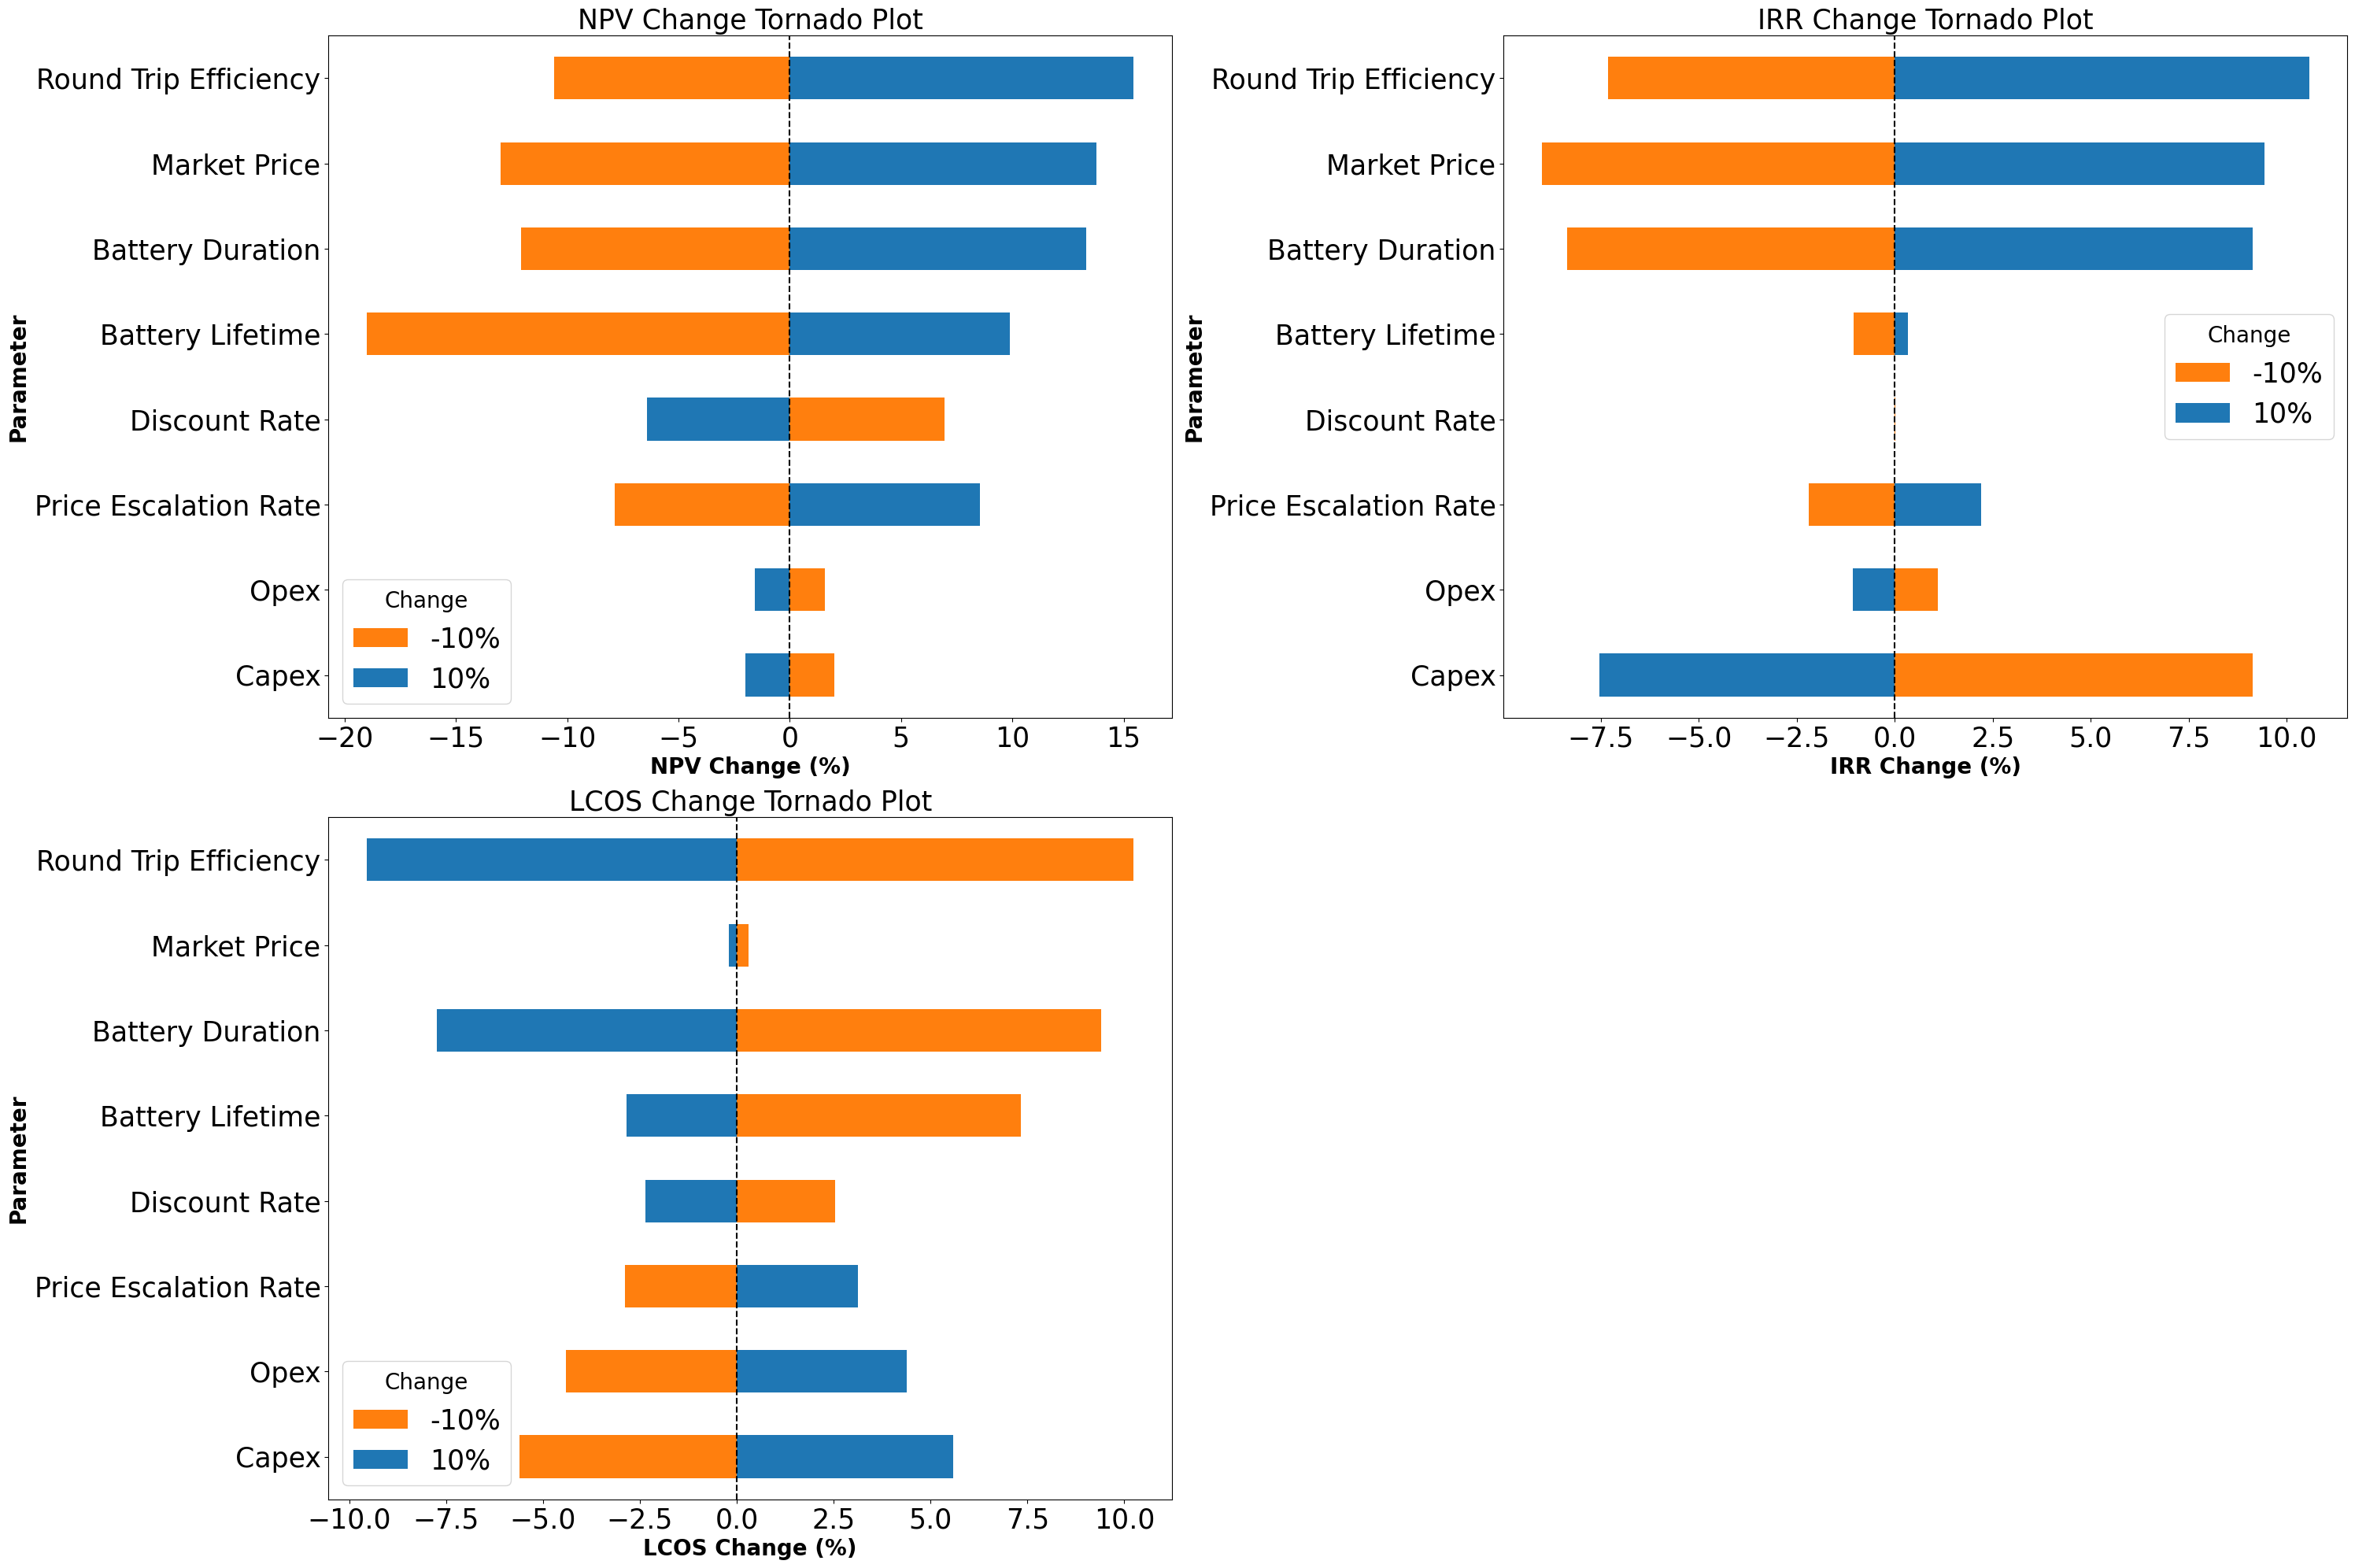

In [4]:
# Load the existing results from the Excel sheet
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Sensitivity/Sensitivity_Analysis_Parameter_Impact_tornado.xlsx'
results_df = pd.read_excel(file_path)

# Parameters to consider
parameters = [
    'Capex',
    'Opex',
    'Price Escalation Rate',
    'Discount Rate',
    'Battery Lifetime',
    'Battery Duration',
    'Market Price',
    'Round Trip Efficiency'
]

# Define colors
colors = ['#ff7f0e','#1f77b4']  # Blue and Orange

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(30, 20))
axs = axs.flatten()

# NPV Change Tornado Plot
npv_changes = results_df.pivot(index='parameter', columns='change', values='NPV Change (%)').loc[parameters]
npv_changes.plot(kind='barh', ax=axs[0], color=colors, stacked=True)
axs[0].set_title('NPV Change Tornado Plot', fontsize=25)
axs[0].set_xlabel('NPV Change (%)', fontsize=20, fontweight='bold')
axs[0].set_ylabel('Parameter', fontsize=20, fontweight='bold')
axs[0].legend(['-10%', '10%'], title='Change', fontsize=25, title_fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=25)
axs[0].axvline(x=0, color='black', linestyle='--')

# IRR Change Tornado Plot
irr_changes = results_df.pivot(index='parameter', columns='change', values='IRR Change (%)').loc[parameters]
irr_changes.plot(kind='barh', ax=axs[1], color=colors, stacked=True)
axs[1].set_title('IRR Change Tornado Plot', fontsize=25)
axs[1].set_xlabel('IRR Change (%)', fontsize=20, fontweight='bold')
axs[1].set_ylabel('Parameter', fontsize=20, fontweight='bold')
axs[1].legend(['-10%', '10%'], title='Change', fontsize=25, title_fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=25)
axs[1].axvline(x=0, color='black', linestyle='--')

# LCOS Change Tornado Plot
lcos_changes = results_df.pivot(index='parameter', columns='change', values='LCOS Change (%)').loc[parameters]
lcos_changes.plot(kind='barh', ax=axs[2], color=colors, stacked=True)
axs[2].set_title('LCOS Change Tornado Plot', fontsize=25)
axs[2].set_xlabel('LCOS Change (%)', fontsize=20, fontweight='bold')
axs[2].set_ylabel('Parameter', fontsize=20, fontweight='bold')
axs[2].legend(['-10%', '10%'], title='Change', fontsize=25, title_fontsize=20)
axs[2].tick_params(axis='both', which='major', labelsize=25)
axs[2].axvline(x=0, color='black', linestyle='--')

# Hide the empty subplot (bottom right)
fig.delaxes(axs[3])

# Adjust layout and save the figure
plt.tight_layout(pad=1.0)
plt.savefig('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Sensitivity/Combined_Tornado_Plot.png')
plt.show()
